# Install packages and Inner Speech Github code

In [ ]:
!git clone https://github.com/N-Nieto/Inner_Speech_Dataset.git
!pip install mne 
!pip install pickle
!pip install mneflow
!pip install pyriemann

Cloning into 'Inner_Speech_Dataset'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 102 (delta 47), reused 2 (delta 0), pack-reused 0
Receiving objects: 100% (102/102), 57.42 KiB | 2.87 MiB/s, done.
Resolving deltas: 100% (47/47), done.
     |████████████████████████████████| 7.4 MB 5.2 MB/s 
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle
     |████████████████████████████████| 49 kB 2.7 MB/s 
     |████████████████████████████████| 42 kB 599 kB/s 
  Created wheel for pyriemann: filename=pyriemann-0.2.7-py2.py3-none-any.whl size=49770 sha256=c30d5b94b95ac5bbc2d3fd338a778d2c92e5b041719553454ee768428c61582d
  Stored in directory: /root/.cache/pip/wheels/5c/b7/55/27dcb08ed8fb58da8c1be108c23928ffb9125c9c1da2ddfb53
Successfully built pyriemann


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data

In [ ]:
import mne 
import pickle
import numpy as np

import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/content/Inner_Speech_Dataset/Python_Processing')
sys.path.insert(1, '/content/drive/MyDrive/CPSC554X_Project/dataset')


from Events_analysis    import Event_correction, Add_condition_tag, Add_block_tag, Delete_trigger
from Events_analysis    import Cognitive_control_check, Standarized_labels, Check_Baseline_tags
from Data_extractions   import Extract_subject_from_BDF
from Utilitys           import Ensure_dir
from AdHoc_modification import adhoc_Subject_3
from EMG_Control        import EMG_control_single_th

# Root where the raw data are stored 
#root_dir = '../'
root_dir = '/content/drive/MyDrive/CPSC554X_Project/dataset/'

# Root where the structured data will be saved - It can be changed and saved in other direction
save_dir = root_dir + "derivatives/"

# Subjects and blacks 
#N_Subj_arr = [1,2,3,4,5,6,7,8,9,10]
N_Subj_arr = [1,2,3,4,5,6,7,8]
N_block_arr = [1,2,3]

##################### Filtering
# Cut-off frequencies
Low_cut = 0.5
High_cut = 100

# Notch filter in 50Hz
Notch_bool = True

# Downsampling rate
DS_rate = 4

##################### ICA 
# If False, ICA is not applyed
ICA_bool = True
ICA_Components = None 
ica_random_state = 23
ica_method = 'infomax'
max_pca_components = None
fit_params = dict(extended=True)

##################### EMG Control
low_f = 1
high_f = 20
# Slide window desing
# Window len (time in sec)
window_len = 0.5
# slide window step (time in sec)
window_step = 0.05

# Threshold 
std_times = 3

# Baseline
t_min_baseline = 0
t_max_baseline = 15

# Trial time
t_min = 1
t_max = 3.5

# In[]: Fixed Variables
# Events ID 
# Trials tag for each class. 
# 31 = Arriba / Up 
# 32 = Abajo / Down
# 33 = Derecha / Right
# 34 = Izquierda / Left
event_id = dict(Arriba = 31, Abajo = 32, Derecha = 33, Izquierda = 34)

#Baseline id
baseline_id = dict(Baseline = 13)

# Report initialization
report = dict(Age = 0, Gender = 0, Recording_time = 0,  Ans_R = 0, Ans_W = 0)

# Montage
Adquisition_eq = "biosemi128"
# Get montage
montage = mne.channels.make_standard_montage(Adquisition_eq)

# Extern channels
Ref_channels = ['EXG1', 'EXG2']

# Gaze detection
Gaze_channels = ['EXG3','EXG4']

# Blinks detection
Blinks_channels = ['EXG5','EXG6']

# Mouth Moving detection
Mouth_channels = ['EXG7','EXG8'] 

# Demographic information
Subject_age = [56,50,34,24,31,29,26,28,35,31]

Subject_gender = ['F','M','M','F','F','M','M','F','M','M'] 

# In[] = Processing loop



### (don't need to run this cell again since it's already in the drive) 

In [ ]:
for N_S in N_Subj_arr:
    # Get Age and Gender
    report['Age'] = Subject_age[N_S-1]
    report['Gender'] = Subject_gender[N_S-1]
    
    for N_B in N_block_arr:
        print('Subject: ' + str (N_S))
        print('Session: ' + str (N_B))
        
        # Load data from BDF file
        rawdata, Num_s = Extract_subject_from_BDF(root_dir,N_S,N_B)
        
        # Referencing
        rawdata.set_eeg_reference(ref_channels=Ref_channels) 
        
        if Notch_bool:
            # Notch filter
            rawdata = mne.io.Raw.notch_filter(rawdata,freqs=50)

        # Filtering raw data
        rawdata.filter(Low_cut, High_cut)
        
        # Get events
        # Subject 10  on Block 1 have a spureos trigger
        if (N_S == 10 and N_B==1):
            events = mne.find_events(rawdata, initial_event = True, consecutive = True,min_duration = 0.002)  
            # The different load of the events delet the spureos trigger but also the Baseline finish mark
        else:
            events = mne.find_events(rawdata, initial_event=True, consecutive=True)    
            
        events = Check_Baseline_tags(events)
            
        # Check and Correct event
        events = Event_correction (N_S=N_S,N_E=N_B,events=events)
        
        # replace the raw events with the new corrected events
        rawdata.event = events
        
        report['Recording_time'] = int(np.round(rawdata.last_samp/rawdata.info['sfreq']))
        
        # Cognitive Control 
        report['Ans_R'] , report['Ans_W'] = Cognitive_control_check(events)

        # In[] Save report
        file_path = save_dir + Num_s + '/ses-0'+ str(N_B) 
        Ensure_dir(file_path)
        file_name = file_path + '/' +Num_s+'_ses-0'+str(N_B)+'_report.pkl'
        with open(file_name, 'wb') as output:
            pickle.dump(report, output, pickle.HIGHEST_PROTOCOL)
            
        # In[]:EXG
        #  the EXG Channels for saving
        picks_eog = mne.pick_types(rawdata.info, eeg = False, stim = False, include = ['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8'])
        epochsEOG = mne.Epochs(rawdata, events, event_id = event_id, tmin = -0.5, tmax = 4,
                               picks = picks_eog, preload = True, detrend = 0, decim = DS_rate)
        
        # Save EOG
        file_name = file_path + '/' +Num_s + '_ses-0' + str(N_B) + '_exg-epo.fif'
        epochsEOG.save(file_name, fmt='double', split_size='2GB', overwrite=True)
        del epochsEOG
        
        # In[]: Baseline
        # Extract Baseline        
        # Calculate the Baseline time 
        t_baseline = (events[events[:,2]==14,0]-events[events[:,2]==13,0])/rawdata.info['sfreq']
        t_baseline = t_baseline[0]        
        Baseline = mne.Epochs(rawdata, events, event_id = baseline_id, tmin = 0, tmax = round(t_baseline),
                              picks = 'all', preload = True, detrend = 0, decim = DS_rate, baseline = None)
        
        # Save Baseline
        file_name = file_path + '/' +Num_s + '_ses-0' + str(N_B) +'_baseline-epo.fif'
        Baseline.save(file_name, fmt = 'double', split_size = '2GB', overwrite = True)
        del Baseline      
        
        # In[ ] Epoching and decimating EEG
        picks_eeg = mne.pick_types(rawdata.info, eeg=True,exclude=['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8'], stim = False)
        epochsEEG = mne.Epochs(rawdata, events, event_id = event_id, tmin = -0.5, tmax = 4,
                               picks = picks_eeg, preload = True, detrend = 0, decim = DS_rate, baseline = None)
        
        # In[]: ICA Prosessing
        
        if ICA_bool:
            # Get a full trials including EXG channels
            picks_vir = mne.pick_types(rawdata.info, eeg=True, include=['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8'], stim=False)
            epochsEEG_full=mne.Epochs(rawdata, events, event_id=event_id, tmin=-0.5, tmax=4,
                                      picks=picks_vir, preload=True, detrend=0, decim=DS_rate, baseline = None)
            
            # Liberate Memory for ICA processing
            del rawdata 
            
            # Creating the ICA object
            ica=mne.preprocessing.ICA(n_components=ICA_Components,random_state=ica_random_state, method=ica_method,fit_params=fit_params)
            
            # Fit ICA, calculate components
            ica.fit(epochsEEG)
            ica.exclude = []    
            
            # Detect sources by correlation
            exg_inds_EXG3, scores_ica = ica.find_bads_eog(epochsEEG_full, ch_name='EXG3')  # find via correlation
            ica.exclude.extend(exg_inds_EXG3)

            # Detect sources by correlation
            exg_inds_EXG4, scores_ica = ica.find_bads_eog(epochsEEG_full, ch_name='EXG4')  # find via correlation  
            ica.exclude.extend(exg_inds_EXG4)
            
            # Detect sources by correlation
            exg_inds_EXG5, scores_ica = ica.find_bads_eog(epochsEEG_full, ch_name='EXG5')  # find via correlation
            ica.exclude.extend(exg_inds_EXG5)
            
            # Detect sources by correlation
            exg_inds_EXG6, scores_ica = ica.find_bads_eog(epochsEEG_full, ch_name='EXG6')  # find via correlation
            ica.exclude.extend(exg_inds_EXG6)
            
            # Detect sources by correlation
            exg_inds_EXG7, scores_ica = ica.find_bads_eog(epochsEEG_full, ch_name='EXG7')  # find via correlation
            ica.exclude.extend(exg_inds_EXG7)
            
            # Detect sources by correlation
            exg_inds_EXG8, scores_ica = ica.find_bads_eog(epochsEEG_full, ch_name='EXG8')  # find via correlation
            ica.exclude.extend(exg_inds_EXG8)
            
            print("Appling ICA")
            ica.apply(epochsEEG)
        
        # In[]
        # Save EEG
        file_name = file_path + '/' +Num_s + '_ses-0' + str(N_B) + '_eeg-epo.fif'
        epochsEEG.save(file_name, fmt='double', split_size='2GB', overwrite=True)
         
        # In[]: Standarize and save events
        events = Add_condition_tag(events)
        events = Add_block_tag(events,N_B=N_B)
        events = Delete_trigger(events)
        events = Standarized_labels (events)

        # Save events
        file_name = file_path + '/' +Num_s + '_ses-0' + str(N_B) + '_events.dat'
        events.dump(file_name)

# In[]: Ad Hoc Modifications
adhoc_Subject_3(root_dir=root_dir)

# In[]: EMG Control
EMG_control_single_th(root_dir=root_dir,N_Subj_arr=N_Subj_arr,N_block_arr=N_block_arr,
                      low_f=low_f,high_f=high_f,t_min=t_min,t_max=t_max,window_len=window_len,
                      window_step=window_step,std_times=std_times,t_min_baseline=t_min_baseline,
                      t_max_baseline=t_max_baseline)

# Visualization

In [ ]:
import matplotlib.pyplot as plt

from Data_extractions import Extract_block_data_from_subject, Extract_data_from_subject
from Data_processing import Filter_by_condition, Filter_by_class
from Utilitys import Ensure_dir, picks_from_channels

# In[] Imports modules

# Root where the data are stored
save_dir = root_dir+ "/ERPs/"

# Subjets
N_S_list=[1,2,3,4,5,6,7,8,9,10]
N_S_list=[1,2,3,4,5,6,7,8]
# Data Parameters
datatype="EEG"
Condition_list=["Pron"]
Classes_list=[ "All"]
channels = "all"

# Saving Parameters
save_bool = True
prefix="ERPs"

#Fix all random states
random_state = 23
np.random.seed(random_state)

#Plotting
# Time Windows
t_start = -0.5
t_end = 4
spatial_colors = True
plot_cues_bool = True
clim = dict(eeg=[-10, 15])
ylim = clim
bandwidth = 2
fontsize = 20
plt.rcParams.update({'font.size': fontsize})
plt.rcParams.update({'legend.framealpha':0})

# In[]: Load Data
N_B = 1
N_S = 1

# Load a single subject to use the Epoched Object structure
X_S , Y = Extract_block_data_from_subject(root_dir,N_S,datatype,N_B=N_B)

Adquisition_eq="biosemi128"
montage = mne.channels.make_standard_montage(Adquisition_eq)
X_S.set_montage(montage)

# Get picks for the selected channels
picks = picks_from_channels(channels)

n_test = 1
for Classes in Classes_list: 
    for Cond in Condition_list:
        count=1
        for N_S in N_S_list:

            # Load full subject's data
            X, Y = Extract_data_from_subject(root_dir, N_S, datatype)
        
            # Filter by condition
            X_cond , Y_cond = Filter_by_condition(X, Y, Condition = Cond)
        
            # Filter by class
            X_class , Y_class =  Filter_by_class(X_cond,Y_cond,Class=Classes)
            
            if count==1:  
                X_data = X_class
                Y_data = Y_class
                count=2
            else:
                X_data = np.vstack((X_data,X_class))
                Y_data = np.vstack((Y_data,Y_class))

        # In[]: Plotting     
        print("Ploting ERPs for Class: " + Classes +" in Condition: " + Cond )
        print("with the information of Subjects: " + str(N_S_list ))        
        
        # Put all data
        X_S._data=X_data
        X_S.events=Y_data
        X_averaged=X_S.average()

        fig= plt.figure(figsize=(20,10))
        axs= fig.add_axes([0.1,0.1,0.8,0.8])
        
        # Plot Cues
        if plot_cues_bool:
            plt.plot([0,0],[-15,15],axes=axs,color='black')
            plt.plot([0.5,0.5],[-15,15],axes=axs,color='black')
            plt.plot([3,3],[-15,15],axes=axs,color='black')
        
        # Plot ERPs
        X_averaged.plot(spatial_colors = spatial_colors, picks = picks, ylim = ylim, axes = axs, xlim= [t_start , t_end])

        title = "ERPs - Condition: " + Cond + " in Class" + Classes
        axs.set_title(title, fontsize = fontsize)
        
        # Save Figure
        if save_bool:
            Ensure_dir(save_dir)
            fig.savefig(save_dir + prefix + '_' + Cond + '_' + Classes + '_' + channels + '_.png', transparent = True)   
        

    Using multitaper spectrum estimation with 1 DPSS windows


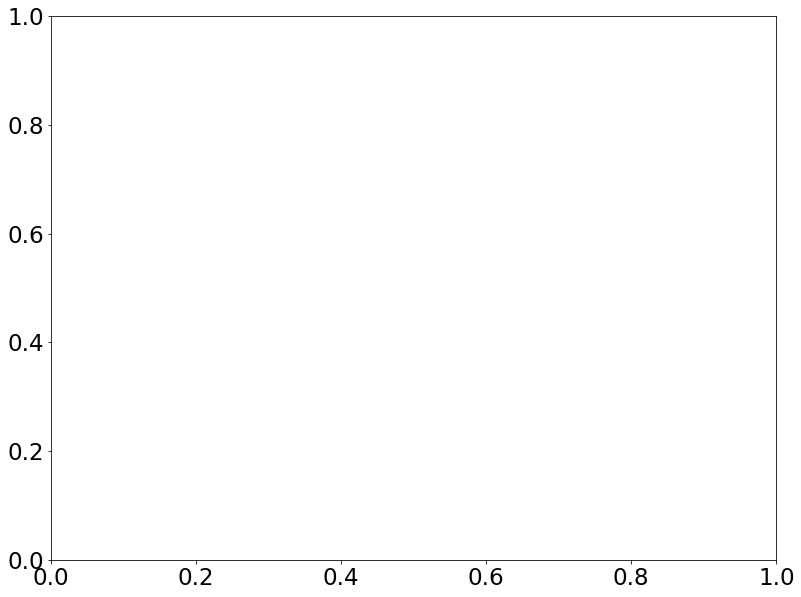

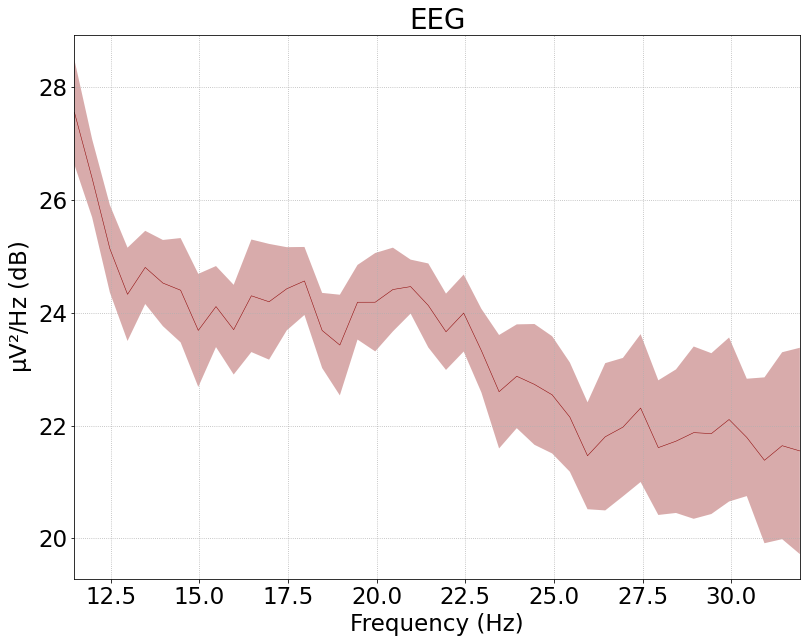

    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows


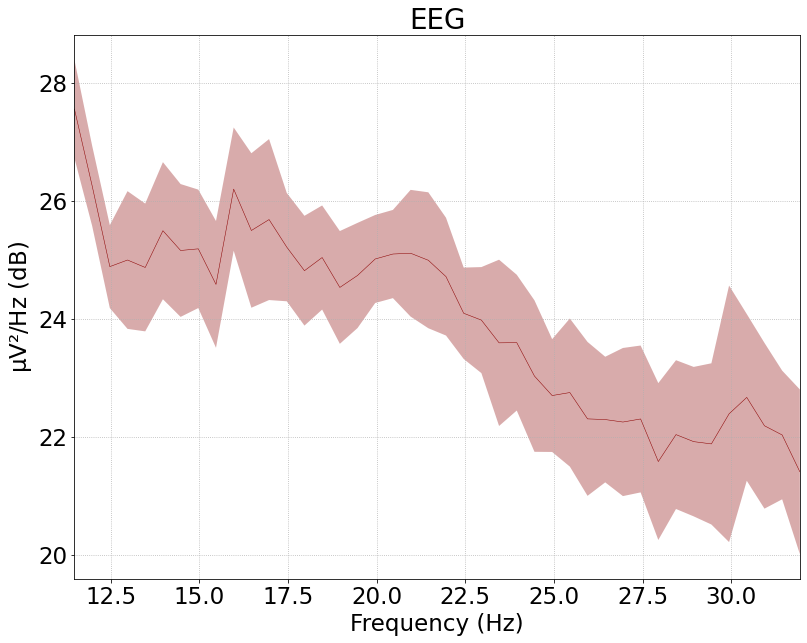

    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows


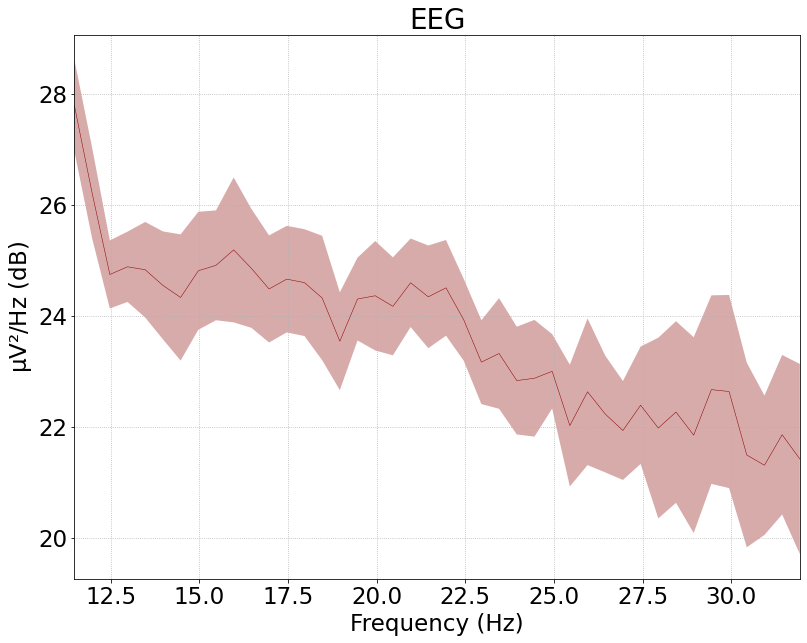

    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows


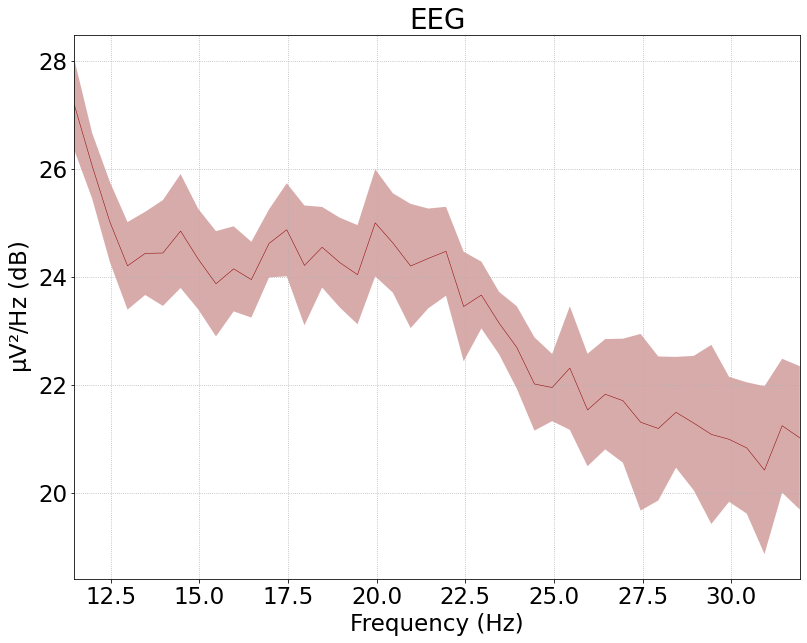

    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows


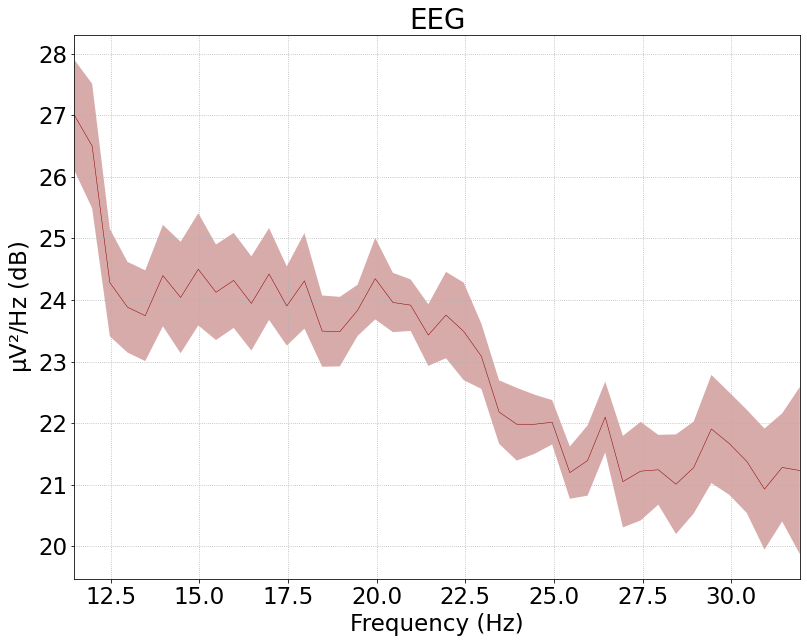

    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows


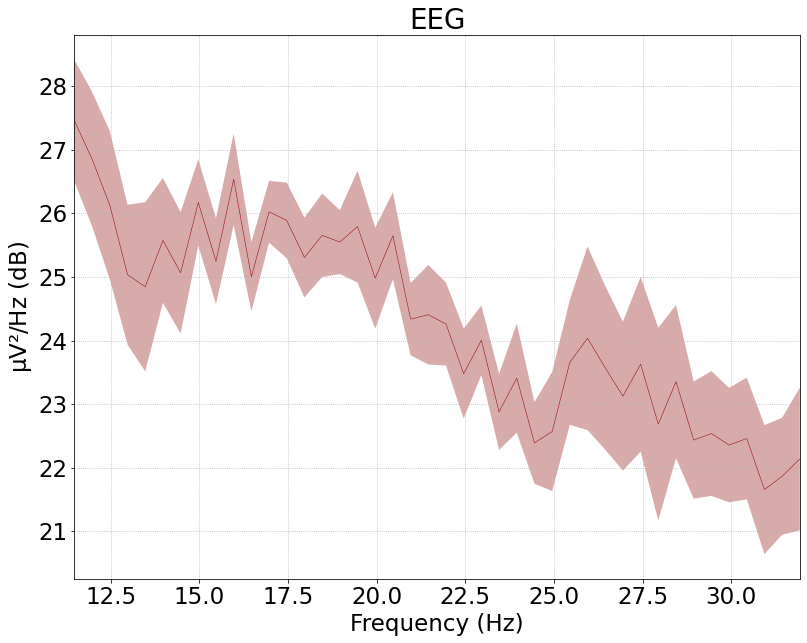

    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows


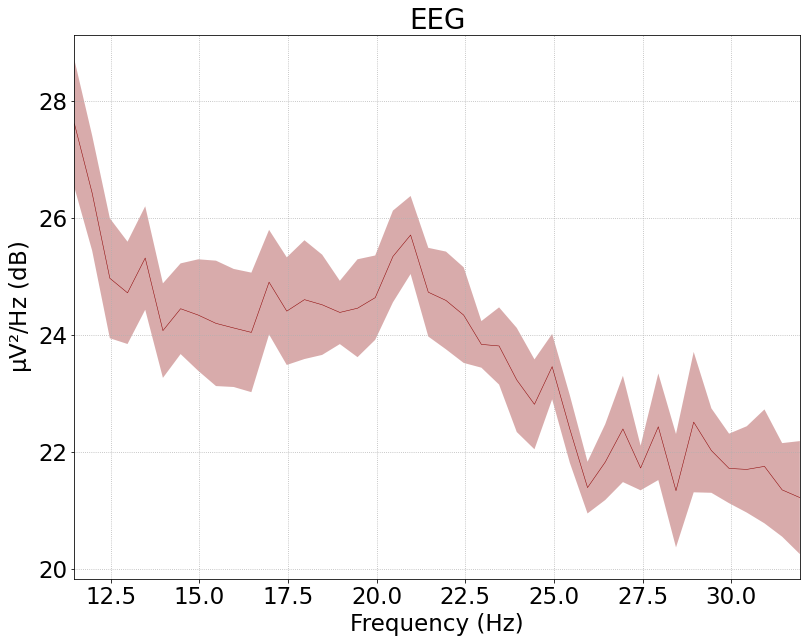

    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows


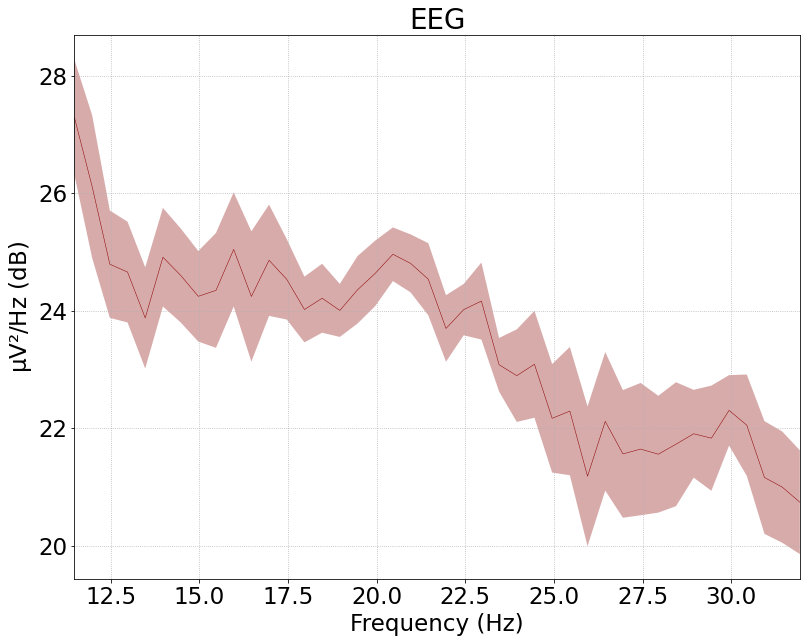

    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows


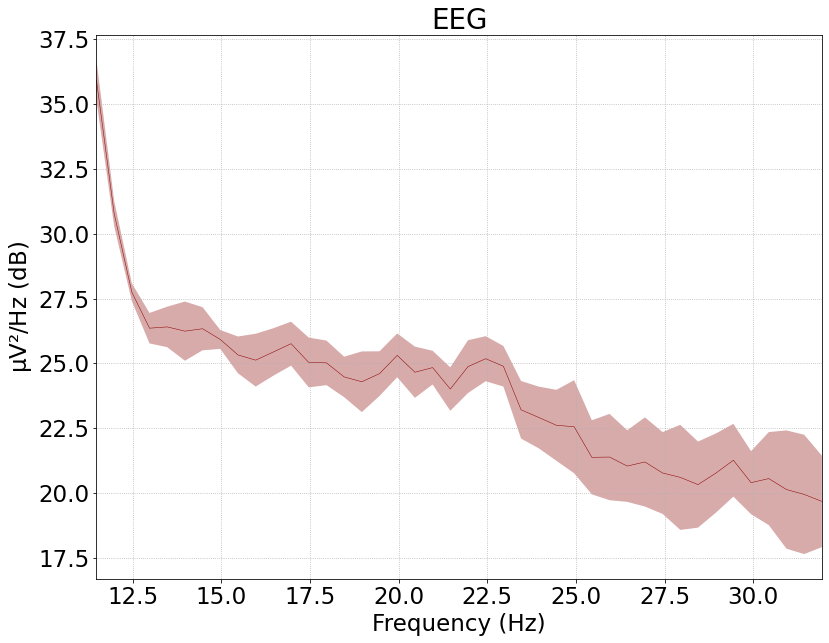

    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows


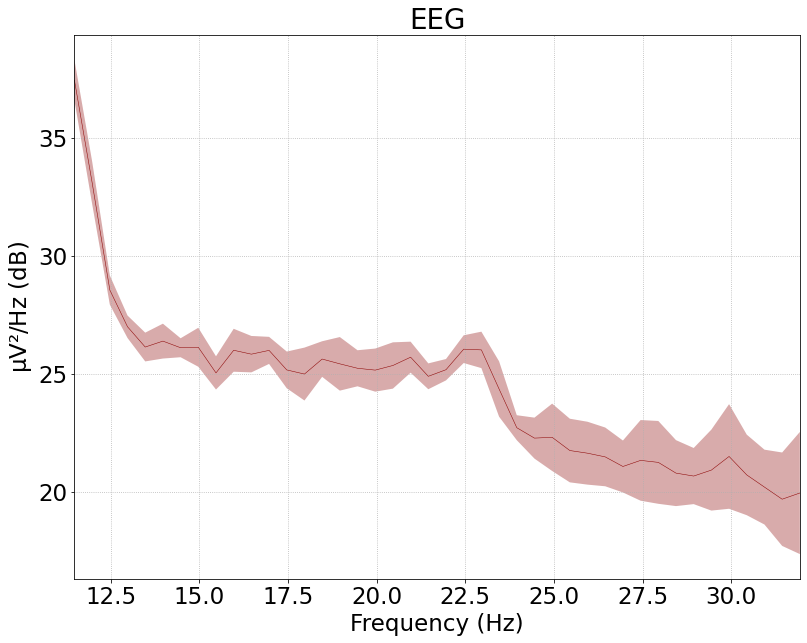

    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows


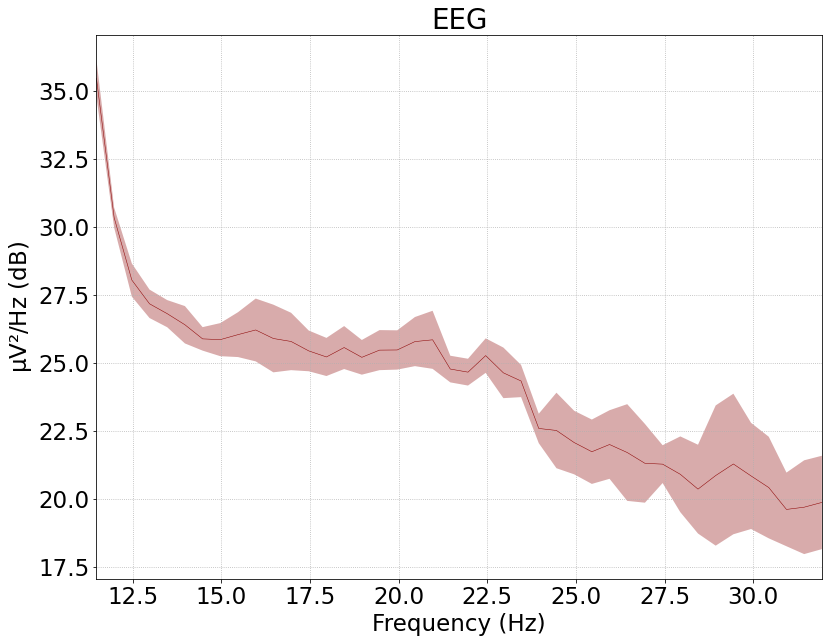

    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows


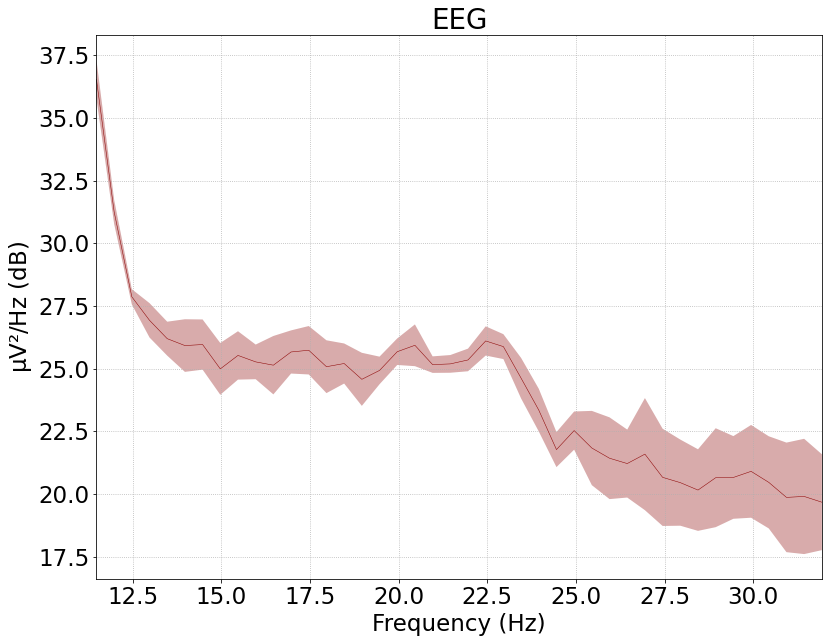

    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows


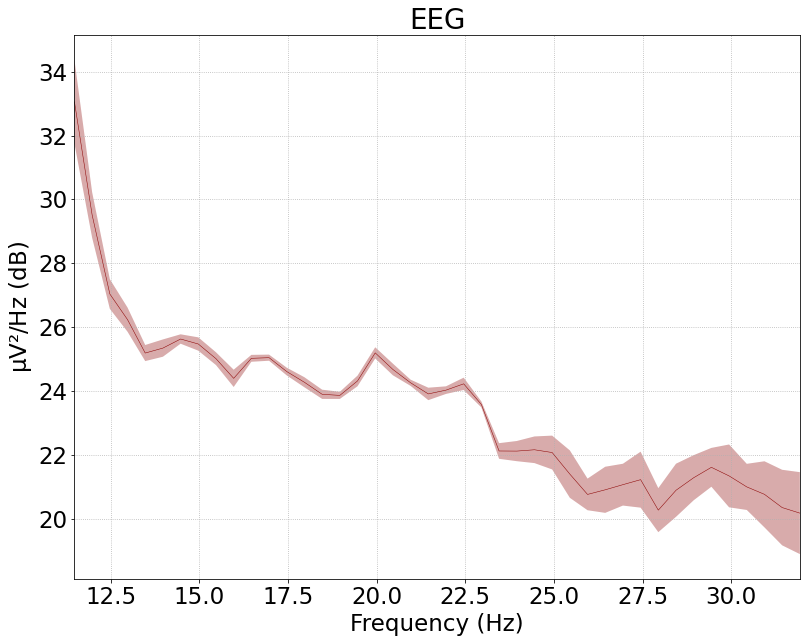

    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows


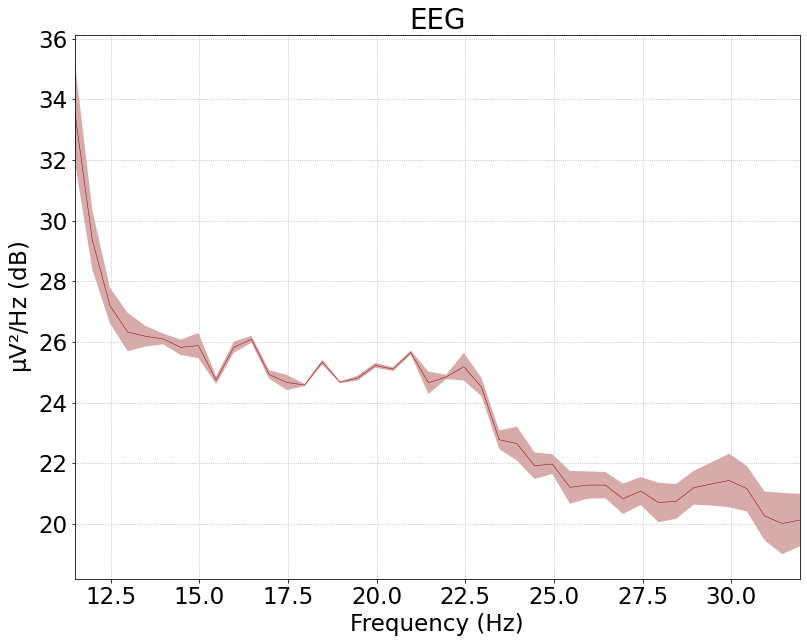

    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows


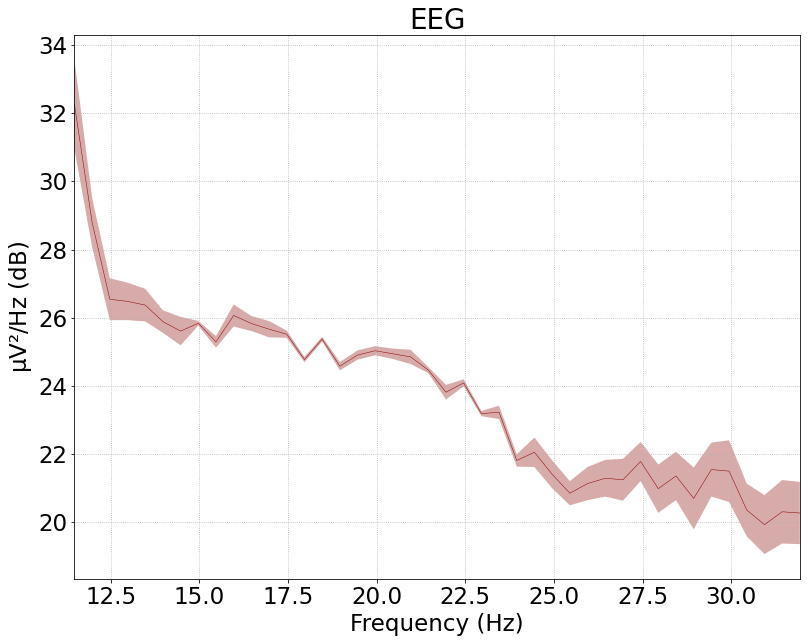

    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows


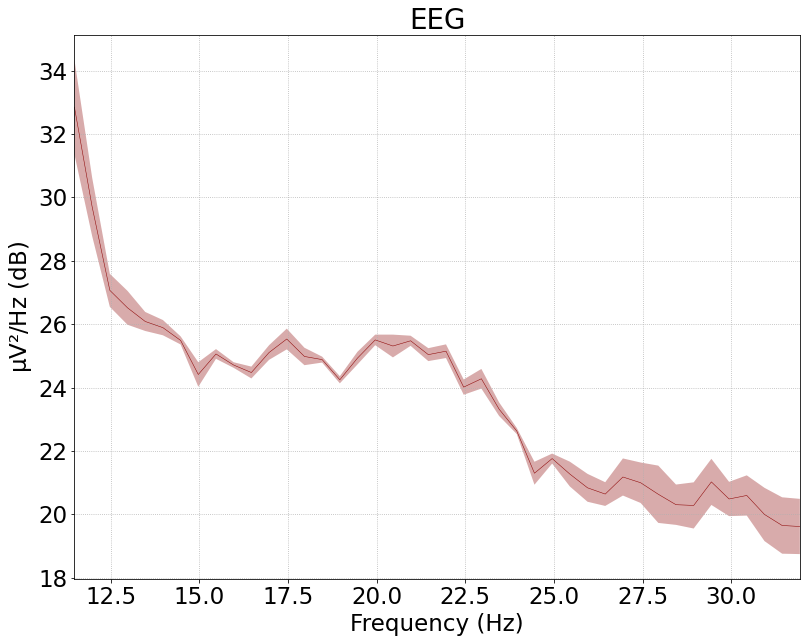

    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows


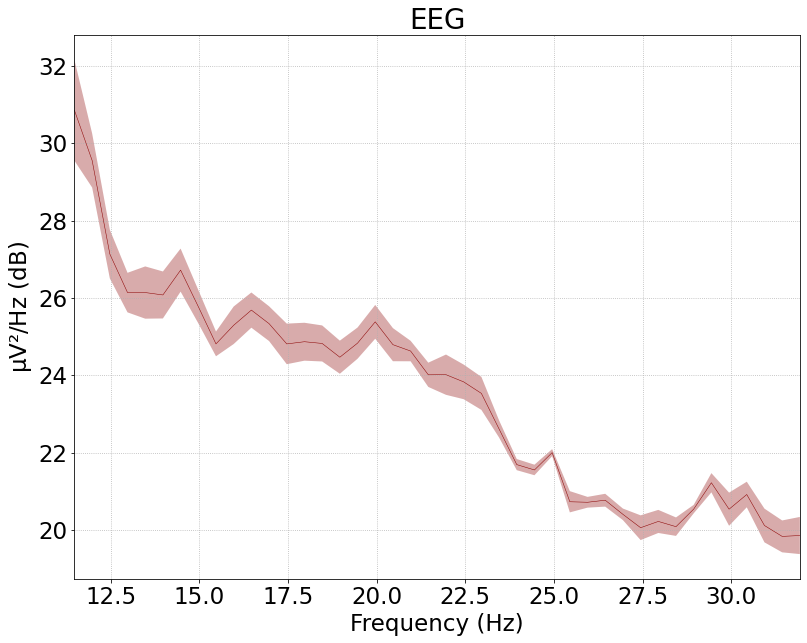

    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows


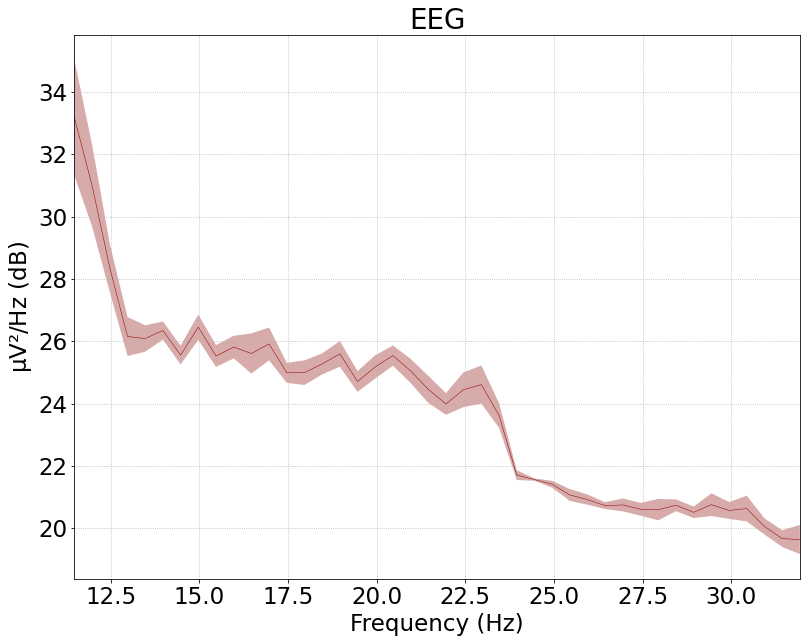

    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows


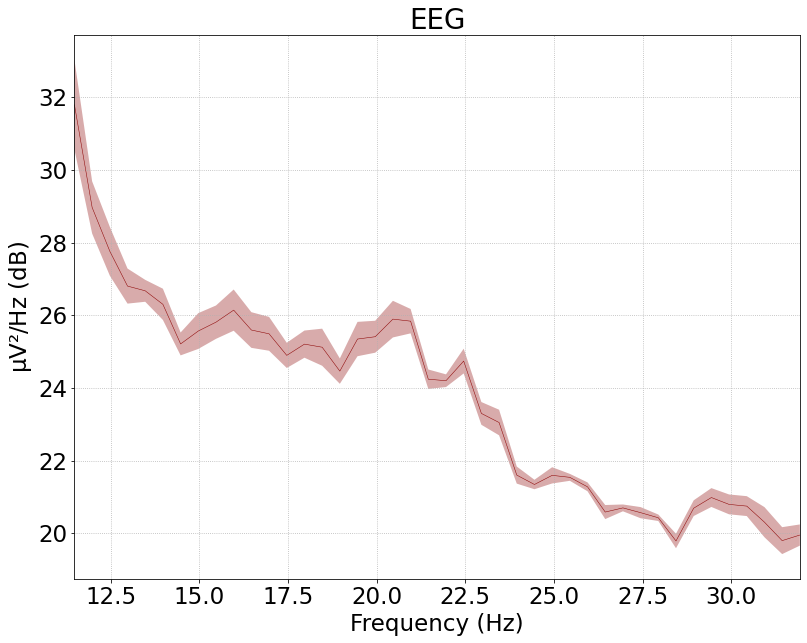

    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows


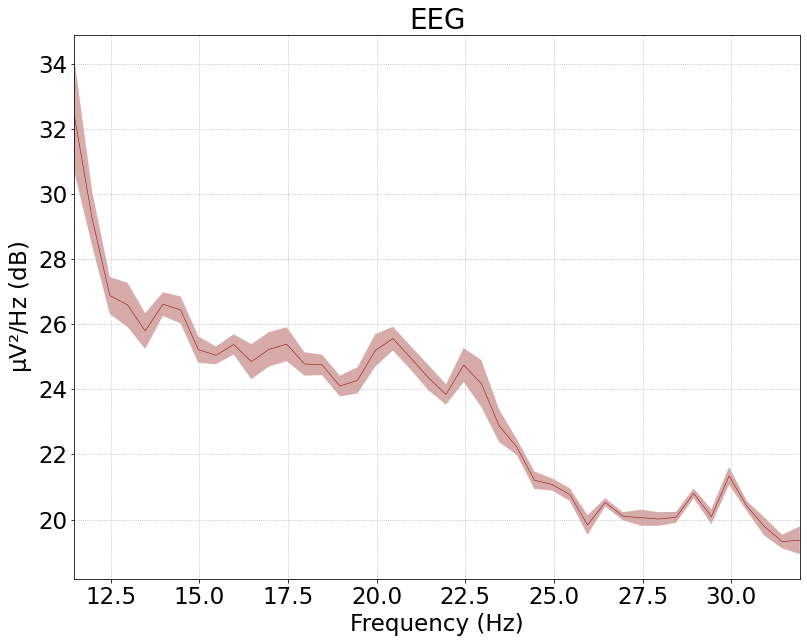

    Using multitaper spectrum estimation with 1 DPSS windows
    Using multitaper spectrum estimation with 1 DPSS windows


In [ ]:
# -*- coding: utf-8 -*-

"""
@author: Nicolás Nieto - nnieto
Power Spectral Density
"""
# In[] Imports modules

import mne
import numpy as np
import matplotlib.pyplot as plt

from Data_extractions import Extract_block_data_from_subject, Extract_data_from_subject
from Data_processing import Filter_by_condition, Filter_by_class
from Utilitys import Ensure_dir, picks_from_channels


# In[]: Processing Variables

# Root where the data are stored
#root_dir = "/media/nnieto/50e793fa-4717-4997-b590-b4167be63ee7/home/nnieto/Escritorio/Nico/Doctorado/Tesis/LIAA - sinc(i)/Toma de datos/Dataset InnerSpeech/"
save_dir = root_dir+"/PSD_Spectrum/"

N_S_list=[1,2,3,4,5,6,7,8]
#N_S_list=[1]
# Data Parameters
datatype="EEG"
Condition_list=["Pron","In", "Vis"]
Classes_list=[ "up", "down", "left", "right"]
#Classes_list=["All"]
channel = "A"
# Get picks for the selected channels
picks = picks_from_channels(channel)
# picks = ["A26"]
channels = ["CL", "CR", "OPZ", "OL", "OR"]

save_bool = True
prefix="Power_Spectral_density_"

#Fix all random states
random_state = 23
np.random.seed(random_state)

#Plotting
# Time Windows
tmin = 1
tmax = 3

fmin = 11
fmax = 32

y_min = 19
y_max = 31
bandwidth = 1
fontsize = 23


plt.rcParams.update({'font.size': fontsize})
plt.rcParams.update({'legend.framealpha':0})
colors = ["darkred","midnightblue","darkcyan", "darkgreen"]    # "midnightblue" - "darkred" - "darkcyan" - "darkgreen"

# In[]: Fix Parameters

N_B = 1
N_S = 1
# Load a single subject to use the Epoched Object structure
X_S,Y= Extract_block_data_from_subject(root_dir,N_S,datatype,N_B=N_B)

Adquisition_eq="biosemi128"
montage=mne.channels.make_standard_montage(Adquisition_eq)
X_S.set_montage(montage)



# In[]: Load Data
fig = plt.figure(figsize = [13, 10])
axs = plt.axes()
n_plot=0
for chan in channels:
  for c2, Classes in enumerate(Classes_list): 
    fig = plt.figure(figsize = [13, 10])
    axs = plt.axes()
    n_plot=0
    for c1, Cond in enumerate(Condition_list):
        count=1
        for N_S in N_S_list:

            # Load full subject's data
            X, Y = Extract_data_from_subject(root_dir, N_S, datatype)
            # Filter by condition
            X_cond , Y_cond = Filter_by_condition(X, Y, Condition = Cond)
        
            # Filter by class
            X_class , Y_class =  Filter_by_class(X_cond,Y_cond,Class=Classes)
            
            if count==1:  
                X_data = X_class
                Y_data = Y_class
                count  = 2
            else:
                X_data = np.vstack((X_data,X_class))
                Y_data = np.vstack((Y_data,Y_class))

        # In[]: Plotting            
        # Put all data
        X_S._data = X_data
        X_S.events = Y_data

        #color = colors[n_plot]
        # for next color
        n_plot = n_plot + 1
        picks = picks_from_channels(chan)
        color = colors[n_plot-1]
        #color = ((c2+1)/len(Classes_list)*(c1 == 0), (c2+1)/len(Classes_list)*(c1 == 1), (c2+1)/len(Classes_list)*(c1 == 2)) 
        fig = X_S.plot_psd(average = True , dB = True, estimate = "power", bandwidth = bandwidth,
                          color = color, picks = picks, fmin = fmin, 
                          fmax = fmax, tmin = tmin , tmax = tmax, ax = axs , )
    # In[]: Saving

    #legend_list = []

    #for i in Classes_list:
    #  for j in ["Pronounced ", "Inner Speech ", "Visualized "]:
    #    legend_list.append(j+i)

    axs.legend( ["Pronounced ", "Inner Speech ", "Visualized "], loc='upper right', borderaxespad=0.9,fontsize=fontsize,shadow=False) 
    axs.set_title(" ",fontsize=fontsize)
    axs.set_ylim(bottom= y_min, top=y_max)

    title = "Power Spectral Density"
    fig.suptitle(title)   

    # Save Figure
    if save_bool:
        Ensure_dir(save_dir)
        fig.savefig(save_dir + prefix + '_' +Classes+"_"+ chan + '_Nov13.png', transparent = True)   

# SVM

### This part is for a single test

In [ ]:
# Authors: Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#          Romain Trachel <romain.trachel@inria.fr>
#
# License: BSD (3-clause)

import numpy as np
import matplotlib.pyplot as plt

import mne
from mne import io

# from mne.datasets import sample
# Root where the raw data are stored 
#root_dir = '../'
root_dir = '/content/drive/MyDrive/CPSC554X_Project/dataset/'

N_S_list = [1,2,3,4,5,6,7,8]
N_B_arr=[1,2,3]
S = 0
epochs = []
data=dict()
y=dict()

# Data Parameters
datatype="EEG"
Condition_list=["Pron","In", "Vis"]
Classes_list=[ "up", "down", "left", "right"]

for N_S in N_S_list:
    for N_B in N_B_arr:

        # name correction if N_Subj is less than 10
        if N_S<10:
            Num_s='sub-0'+str(N_S)
        else:
            Num_s='sub-'+str(N_S)
            
        file_name = root_dir + '/derivatives/' + Num_s + '/ses-0'+ str(N_B) + '/' +Num_s+'_ses-0'+str(N_B)+'_eeg-epo.fif'
        X = mne.read_epochs(file_name,verbose='WARNING')
        epochs.append(X)
        data[N_B]= X._data

        file_name = root_dir + '/derivatives/' + Num_s + '/ses-0'+ str(N_B) + '/' +Num_s+'_ses-0'+str(N_B)+'_events.dat'
        y[N_B] = np.load(file_name,allow_pickle=True)

In [ ]:
X._data

array([[[-1.65488721e-05, -2.22937621e-05, -2.76651499e-05, ...,
         -2.09250830e-06,  1.74993252e-06,  5.68605559e-06],
        [-1.71029060e-05, -2.23113139e-05, -2.79933832e-05, ...,
         -3.50806123e-06,  1.90448816e-06,  5.81159507e-06],
        [-3.08837103e-05, -3.78548272e-05, -4.16012307e-05, ...,
         -3.44209195e-06,  6.73911218e-07,  5.17469971e-06],
        ...,
        [-3.12426989e-05, -3.65583191e-05, -4.06084887e-05, ...,
          3.45851711e-06,  6.27395419e-06,  6.76463771e-06],
        [-1.62803953e-05, -1.98325357e-05, -1.64767583e-05, ...,
          1.12876092e-05,  6.54847320e-06,  8.43053144e-06],
        [-1.68174875e-05, -2.11740062e-05, -1.79511316e-05, ...,
          1.03345432e-05,  6.17508726e-06,  7.87265658e-06]],

       [[ 9.08671326e-06,  3.57781247e-06,  4.73806427e-07, ...,
          8.11275459e-06,  9.03730329e-06,  8.55802722e-06],
        [ 8.30072640e-06,  2.53126680e-06, -1.55505258e-06, ...,
          8.48764945e-06,  9.06796349e

In [ ]:
epochs

[<EpochsFIF |  200 events (all good), -0.5 - 4 sec, baseline off, ~225.3 MB, data loaded,
  'Abajo': 50
  'Arriba': 50
  'Derecha': 50
  'Izquierda': 50>,
 <EpochsFIF |  200 events (all good), -0.5 - 4 sec, baseline off, ~225.3 MB, data loaded,
  'Abajo': 50
  'Arriba': 50
  'Derecha': 50
  'Izquierda': 50>,
 <EpochsFIF |  100 events (all good), -0.5 - 4 sec, baseline off, ~112.7 MB, data loaded,
  'Abajo': 25
  'Arriba': 25
  'Derecha': 25
  'Izquierda': 25>,
 <EpochsFIF |  200 events (all good), -0.5 - 4 sec, baseline off, ~225.3 MB, data loaded,
  'Abajo': 50
  'Arriba': 50
  'Derecha': 50
  'Izquierda': 50>,
 <EpochsFIF |  200 events (all good), -0.5 - 4 sec, baseline off, ~225.3 MB, data loaded,
  'Abajo': 50
  'Arriba': 50
  'Derecha': 50
  'Izquierda': 50>,
 <EpochsFIF |  200 events (all good), -0.5 - 4 sec, baseline off, ~225.3 MB, data loaded,
  'Abajo': 50
  'Arriba': 50
  'Derecha': 50
  'Izquierda': 50>,
 <EpochsFIF |  200 events (all good), -0.5 - 4 sec, baseline off, ~225

In [ ]:
y

{1: array([[  40535,       3,       0,       1],
        [  47190,       3,       0,       1],
        [  53761,       0,       0,       1],
        [  60161,       3,       0,       1],
        [  66663,       1,       0,       1],
        [  73097,       0,       0,       1],
        [  79582,       0,       0,       1],
        [  86101,       3,       0,       1],
        [  92672,       3,       0,       1],
        [  99072,       1,       0,       1],
        [ 105915,       1,       0,       1],
        [ 112759,       1,       0,       1],
        [ 119380,       1,       0,       1],
        [ 126002,       3,       0,       1],
        [ 132573,       2,       0,       1],
        [ 139382,       3,       0,       1],
        [ 145935,       0,       0,       1],
        [ 152369,       3,       0,       1],
        [ 159162,       0,       0,       1],
        [ 165749,       3,       0,       1],
        [ 172251,       0,       0,       1],
        [ 178805,       1,     

In [ ]:
Y

array([[ 40535,      3,      0,      1],
       [ 47190,      3,      0,      1],
       [ 53761,      0,      0,      1],
       ...,
       [920636,      3,      2,      3],
       [934442,      2,      2,      3],
       [941268,      3,      2,      3]])

In [ ]:
[psd_all, freqs] = mne.time_frequency.psd_welch(X_S)

Effective window size : 1.000 (s)


### Classify Paradigm: Event = {0,1,2} -> Pron-Inner-Vis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne import io
from Data_extractions import Extract_block_data_from_subject, Extract_data_from_subject
from Data_processing import Filter_by_condition, Filter_by_class
from Utilitys import Ensure_dir, picks_from_channels

root_dir = '/content/drive/MyDrive/CPSC554X_Project/dataset'
N_S_list = [1,2,3,4,5,6,7,8]

N_B_arr=[1,2,3]
S = 0
epochs = []
data=dict()
y=dict()

# Data Parameters
datatype="EEG"
#Condition_list=["Pron","In", "Vis"]
Condition_list = ["all"]
#Classes_list=[ "up", "down", "left", "right"]
Classes_list = [ "all"]
#channels = ["CL", "CR", "OPZ", "OL", "OR"] # paradigm
channels = ["OZ", "OL", "CR", "CL", "FZ", "FR"] #class
picks = []

# Get picks for the selected channels
for i in channels:
  picks.append(picks_from_channels(i))

picks = np.concatenate(picks)
picks.tolist()

# In[]: Load Data
N_B = 1
N_S = 1

# Load a single subject to use the Epoched Object structure
X_S , Y = Extract_block_data_from_subject(root_dir,N_S,datatype,N_B=N_B)

Adquisition_eq="biosemi128"
montage = mne.channels.make_standard_montage(Adquisition_eq)
X_S.set_montage(montage)

# Get picks for the selected channels
count=1

for Classes in Classes_list: 
  for Cond in Condition_list:

    for N_S in N_S_list:

        # Load full subject's data
        X1, Y1 = Extract_data_from_subject(root_dir, N_S, datatype)

        # Filter by condition
        X_cond , Y_cond = Filter_by_condition(X1,Y1,Condition=Cond)

        # Filter by class
        X_class , Y_class = Filter_by_class(X_cond,Y_cond,Class=Classes)
        
        if count==1:  
            X_data = X_class
            Y_data = Y_class
        #    X_data = X1
        #    Y_data = Y1
            count=2
        else:
            #X_data = np.vstack((X_data,X1))
            #Y_data = np.vstack((Y_data,Y1))
            X_data = np.vstack((X_data,X_class))
            Y_data = np.vstack((Y_data,Y_class))

# Put all data
X_S._data=X_data
X_S.events=Y_data
X_S = X_S.pick_channels(picks)
X_S = X_S.crop(tmin = 0, tmax = 4)
X_data = X_S._data
labels = X_S.events[:, 2]

In [ ]:
print(labels)
print(X_S.events)

[0 0 0 ... 2 2 2]
[[ 39869      3      0      1]
 [ 46491      0      0      1]
 [ 53010      3      0      1]
 ...
 [920636      3      2      3]
 [934442      2      2      3]
 [941268      3      2      3]]


Computing rank from data with rank=None
    Using tolerance 0.00028 (2.2e-16 eps * 21 dim * 6.1e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00027 (2.2e-16 eps * 21 dim * 5.7e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00027 (2.2e-16 eps * 21 dim * 5.8e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using LEDOIT_WOLF
Done.


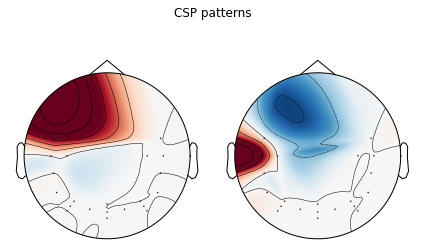

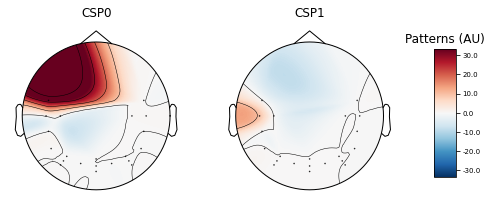

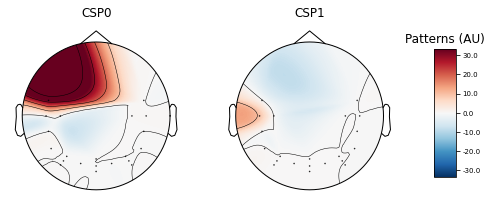

In [ ]:
# plot CSP patterns estimated on full data for visualization
from mne.decoding import CSP  # noqa
n_components = 2  # pick some components(default=4)
csp = CSP(n_components=n_components, reg='ledoit_wolf', norm_trace=False)
csp.fit_transform(X_S.get_data(), labels)
data = csp.patterns_

import matplotlib.pyplot as plt

evoked = X_S.average() # https://mne.tools/stable/auto_tutorials/evoked/10_evoked_overview.html

fig, axes = plt.subplots(1, 2)
for idx in range(2):
    mne.viz.plot_topomap(data[idx], X_S.info, axes=axes[idx], show=False)
fig.suptitle('CSP patterns')
fig.tight_layout()
mne.viz.utils.plt_show()

# https://mne.tools/stable/auto_examples/decoding/decoding_csp_eeg.html
csp.plot_patterns(evoked.info, ch_type='eeg', units='Patterns (AU)', size=2)

In [ ]:
print(evoked.info)

<Info | 11 non-empty values
 bads: []
 ch_names: A8, A9, A10, A17, A20, A21, A22, A30, B5, B6, B7, B12, B16, B22, ...
 chs: 21 EEG
 custom_ref_applied: True
 dig: 131 items (3 Cardinal, 128 EEG)
 file_id: 4 items (dict)
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: 2019-08-20 10:57:41 UTC
 meas_id: 4 items (dict)
 nchan: 21
 projs: []
 sfreq: 256.0 Hz
>


In [ ]:
from sklearn.svm import SVC  # noqa
from sklearn.model_selection import ShuffleSplit  # noqa
from mne.decoding import CSP  # noqa
from sklearn.pipeline import Pipeline  # noqa
from sklearn.model_selection import cross_val_score  # noqa
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

#epochs_data = psd_all
epochs_data = X_data

scores = []
# https://mne.tools/0.16/auto_examples/decoding/plot_decoding_csp_space.html
n_components = 4  # pick some components(default=4)
svc = SVC(C=1, kernel='linear')
csp = CSP(n_components=n_components, reg='ledoit_wolf', norm_trace=False)

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

clf = Pipeline([('CSP', csp), ('SVC', svc)])

for train_idx, test_idx in cv.split(labels):
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data[train_idx], y_train)
    X_test = csp.transform(epochs_data[test_idx])

    # fit classifier
    svc.fit(X_train, y_train)

    scores.append(svc.score(X_test, y_test))
    
# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f"%(np.mean(scores),class_balance))
# Classification accuracy: 0.454842 / Chance level: 0.800000

Computing rank from data with rank=None
    Using tolerance 0.00037 (2.2e-16 eps * 25 dim * 6.7e+10  max singular value)
    Estimated rank (mag): 25
    MAG: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00033 (2.2e-16 eps * 25 dim * 6e+10  max singular value)
    Estimated rank (mag): 25
    MAG: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00032 (2.2e-16 eps * 25 dim * 5.8e+10  max singular value)
    Estimated rank (mag): 25
    MAG: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00038 (2.2e-16 eps * 25 dim * 6.8e+10  max singular val

In [ ]:
from sklearn.svm import SVC  # noqa
from sklearn.model_selection import ShuffleSplit  # noqa
from mne.decoding import CSP  # noqa
from sklearn.pipeline import Pipeline  # noqa
from sklearn.model_selection import cross_val_score  # noqa
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

#epochs_data = psd_all
#epochs_data = X_data
epochs_data = np.concatenate((X_data[:, :, 0:250], X_data[:, :, 250:500],X_data[:, :, 500:750],X_data[:, :, 750:1000]),axis = 0)
labels = np.concatenate((X_S.events[:, 2],X_S.events[:, 2],X_S.events[:, 2],X_S.events[:, 2]), axis = 0)

scores = []
# https://mne.tools/0.16/auto_examples/decoding/plot_decoding_csp_space.html
n_components = 4  # pick some components(default=4)
svc = SVC(C=1, kernel='linear')
csp = CSP(n_components=n_components, reg='ledoit_wolf', norm_trace=False)

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

clf = Pipeline([('CSP', csp), ('SVC', svc)])

for train_idx, test_idx in cv.split(labels):
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data[train_idx], y_train)
    X_test = csp.transform(epochs_data[test_idx])

    # fit classifier
    svc.fit(X_train, y_train)

    scores.append(svc.score(X_test, y_test))
    
# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f"%(np.mean(scores),class_balance))
# Classification accuracy: 0.438401 / Chance level: 0.800000

Computing rank from data with rank=None
    Using tolerance 0.00037 (2.2e-16 eps * 25 dim * 6.6e+10  max singular value)
    Estimated rank (mag): 25
    MAG: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00032 (2.2e-16 eps * 25 dim * 5.8e+10  max singular value)
    Estimated rank (mag): 25
    MAG: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00032 (2.2e-16 eps * 25 dim * 5.7e+10  max singular value)
    Estimated rank (mag): 25
    MAG: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00037 (2.2e-16 eps * 25 dim * 6.6e+10  max singular v

In [ ]:
from sklearn.svm import SVC  # noqa
from sklearn.model_selection import ShuffleSplit  # noqa
from mne.decoding import CSP  # noqa
from sklearn.pipeline import Pipeline  # noqa
from sklearn.model_selection import cross_val_score  # noqa

# https://mne.tools/0.16/auto_examples/decoding/plot_decoding_csp_space.html
n_components = 4  # pick some components(default=4)
svc = SVC(C=1, kernel='sigmoid')
csp = CSP(n_components=n_components, reg='ledoit_wolf', norm_trace=False)
# Define a monte-carlo cross-validation generator (reduce variance):
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
scores = []
epochs_data = X_data

for train_idx, test_idx in cv.split(labels):
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data[train_idx], y_train)
    X_test = csp.transform(epochs_data[test_idx])

    # fit classifier
    svc.fit(X_train, y_train)

    scores.append(svc.score(X_test, y_test))


# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f"%(np.mean(scores),class_balance))
# Classification accuracy: 0.359459 / Chance level: 0.800000

Computing rank from data with rank=None
    Using tolerance 0.00037 (2.2e-16 eps * 25 dim * 6.7e+10  max singular value)
    Estimated rank (mag): 25
    MAG: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00033 (2.2e-16 eps * 25 dim * 6e+10  max singular value)
    Estimated rank (mag): 25
    MAG: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00032 (2.2e-16 eps * 25 dim * 5.8e+10  max singular value)
    Estimated rank (mag): 25
    MAG: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00038 (2.2e-16 eps * 25 dim * 6.8e+10  max singular val

In [ ]:
from sklearn.svm import SVC  # noqa
from sklearn.model_selection import ShuffleSplit  # noqa
from mne.decoding import CSP  # noqa
from sklearn.pipeline import Pipeline  # noqa
from sklearn.model_selection import cross_val_score  # noqa

# https://mne.tools/0.16/auto_examples/decoding/plot_decoding_csp_space.html
n_components = 4  # pick some components(default=4)
svc = SVC(C=1, kernel='sigmoid')
csp = CSP(n_components=n_components, reg='ledoit_wolf', norm_trace=False)
# Define a monte-carlo cross-validation generator (reduce variance):
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
scores = []
#epochs_data = X_data
epochs_data = np.concatenate((X_data[:, :, 0:250], X_data[:, :, 250:500],X_data[:, :, 500:750],X_data[:, :, 750:1000]),axis = 0)
labels = np.concatenate((X_S.events[:, 2],X_S.events[:, 2],X_S.events[:, 2],X_S.events[:, 2]), axis = 0)

for train_idx, test_idx in cv.split(labels):
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data[train_idx], y_train)
    X_test = csp.transform(epochs_data[test_idx])

    # fit classifier
    svc.fit(X_train, y_train)

    scores.append(svc.score(X_test, y_test))


# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f"%(np.mean(scores),class_balance))
# Classification accuracy: 0.369172 / Chance level: 0.800000

Computing rank from data with rank=None
    Using tolerance 0.00037 (2.2e-16 eps * 25 dim * 6.6e+10  max singular value)
    Estimated rank (mag): 25
    MAG: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00032 (2.2e-16 eps * 25 dim * 5.8e+10  max singular value)
    Estimated rank (mag): 25
    MAG: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00032 (2.2e-16 eps * 25 dim * 5.7e+10  max singular value)
    Estimated rank (mag): 25
    MAG: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00037 (2.2e-16 eps * 25 dim * 6.6e+10  max singular v

In [ ]:
from sklearn.svm import SVC  # noqa
from sklearn.model_selection import ShuffleSplit  # noqa
from mne.decoding import CSP  # noqa
from sklearn.pipeline import Pipeline  # noqa
from sklearn.model_selection import cross_val_score  # noqa

n_components = 4  # pick some components(default=4)
svc = SVC(kernel='rbf', class_weight='balanced', C=10, gamma=1)
csp = CSP(n_components=n_components, reg='ledoit_wolf', norm_trace=False)
# Define a monte-carlo cross-validation generator (reduce variance):
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
scores = []
epochs_data = X_S.get_data()

for train_idx, test_idx in cv.split(labels):
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data[train_idx], y_train)
    X_test = csp.transform(epochs_data[test_idx])

    # fit classifier
    svc.fit(X_train, y_train)

    scores.append(svc.score(X_test, y_test))

class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f"%(np.mean(scores),class_balance))
# Classification accuracy: 0.597185 / Chance level: 0.800000

Computing rank from data with rank=None
    Using tolerance 0.00037 (2.2e-16 eps * 25 dim * 6.7e+10  max singular value)
    Estimated rank (mag): 25
    MAG: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00033 (2.2e-16 eps * 25 dim * 6e+10  max singular value)
    Estimated rank (mag): 25
    MAG: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00032 (2.2e-16 eps * 25 dim * 5.8e+10  max singular value)
    Estimated rank (mag): 25
    MAG: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00038 (2.2e-16 eps * 25 dim * 6.8e+10  max singular val

In [ ]:
from sklearn.svm import SVC  # noqa
from sklearn.model_selection import ShuffleSplit  # noqa
from mne.decoding import CSP  # noqa
from sklearn.pipeline import Pipeline  # noqa
from sklearn.model_selection import cross_val_score  # noqa

n_components = 4  # pick some components(default=4)
svc = SVC(kernel='rbf', class_weight='balanced', C=10, gamma=1)
csp = CSP(n_components=n_components, reg='ledoit_wolf', norm_trace=False)
# Define a monte-carlo cross-validation generator (reduce variance):
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
scores = []
#epochs_data = psd_all
#epochs_data = X_data
epochs_data = np.concatenate((X_data[:, :, 0:250], X_data[:, :, 250:500],X_data[:, :, 500:750],X_data[:, :, 750:1000]),axis = 0)
labels = np.concatenate((X_S.events[:, 2],X_S.events[:, 2],X_S.events[:, 2],X_S.events[:, 2]), axis = 0)

for train_idx, test_idx in cv.split(labels):
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data[train_idx], y_train)
    X_test = csp.transform(epochs_data[test_idx])

    # fit classifier
    svc.fit(X_train, y_train)

    scores.append(svc.score(X_test, y_test))

class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f"%(np.mean(scores),class_balance))
# Classification accuracy: 0.530377 / Chance level: 0.800000

Computing rank from data with rank=None
    Using tolerance 0.00037 (2.2e-16 eps * 25 dim * 6.6e+10  max singular value)
    Estimated rank (mag): 25
    MAG: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00032 (2.2e-16 eps * 25 dim * 5.8e+10  max singular value)
    Estimated rank (mag): 25
    MAG: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00032 (2.2e-16 eps * 25 dim * 5.7e+10  max singular value)
    Estimated rank (mag): 25
    MAG: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00037 (2.2e-16 eps * 25 dim * 6.6e+10  max singular v

### Classify Word: Event = {31,32,33,34} -> Up-Down-Right-Left

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne import io
from Data_extractions import Extract_block_data_from_subject, Extract_data_from_subject
from Data_processing import Filter_by_condition, Filter_by_class
from Utilitys import Ensure_dir, picks_from_channels

root_dir = '/content/drive/MyDrive/CPSC554X_Project/dataset'
N_S_list = [1,2,3,4,5,6,7,8]
N_B_arr=[1,2,3]
S = 0
epochs = []
data=dict()
y=dict()

# Data Parameters
datatype="EEG"
#Condition_list=["Pron","In", "Vis"]
Condition_list = ["Inner"]
#Classes_list=[ "up", "down", "left", "right"]
Classes_list = [ "all"]
channels = ["CL", "CR", "OPZ", "OL", "OR"] # paradigm
#channels = ["OZ", "OL", "CR", "CL", "FZ", "FR"] #class
picks = []

# Get picks for the selected channels
for i in channels:
  picks.append(picks_from_channels(i))

picks = np.concatenate(picks)
picks.tolist()

# In[]: Load Data
N_B = 1
N_S = 1

# Load a single subject to use the Epoched Object structure
X_S , Y = Extract_block_data_from_subject(root_dir,N_S,datatype,N_B=N_B)

Adquisition_eq="biosemi128"
montage = mne.channels.make_standard_montage(Adquisition_eq)
X_S.set_montage(montage)

# Get picks for the selected channels
count=1

for Classes in Classes_list: 
  for Cond in Condition_list:

    for N_S in N_S_list:

        # Load full subject's data
        X1, Y1 = Extract_data_from_subject(root_dir, N_S, datatype)

        # Filter by condition
        X_cond , Y_cond = Filter_by_condition(X1,Y1,Condition=Cond)
        Y_cond[:,1] = Y_cond[:,1] + 31
        Y_cond[:, [1, 2]] = Y_cond[:, [2, 1]]
        
        # Filter by class
        X_class , Y_class = Filter_by_class(X_cond,Y_cond,Class=Classes)
        
        if count==1:  
            X_data = X_class
            Y_data = Y_class
        #    X_data = X1
        #    Y_data = Y1
            count=2
        else:
            #X_data = np.vstack((X_data,X1))
            #Y_data = np.vstack((Y_data,Y1))
            X_data = np.vstack((X_data,X_class))
            Y_data = np.vstack((Y_data,Y_class))

# Put all data
X_S._data=X_data
X_S.events=Y_data
X_S = X_S.pick_channels(picks)
X_S = X_S.crop(tmin = 0, tmax = 4)
X_data = X_S._data
labels = X_S.events[:, 2]

In [ ]:
print(labels)
print(X_S.events)# plot CSP patterns estimated on full data for visualization

[32 32 34 ... 32 31 33]
[[351788      1     32      1]
 [358546      1     32      1]
 [365390      1     34      1]
 ...
 [541544      1     32      3]
 [548422      1     31      3]
 [554822      1     33      3]]


Computing rank from data with rank=None
    Using tolerance 0.00012 (2.2e-16 eps * 21 dim * 2.7e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00013 (2.2e-16 eps * 21 dim * 2.7e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00012 (2.2e-16 eps * 21 dim * 2.7e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00013 (2.2e-16 eps * 21 dim * 2.8e+10  max singular v

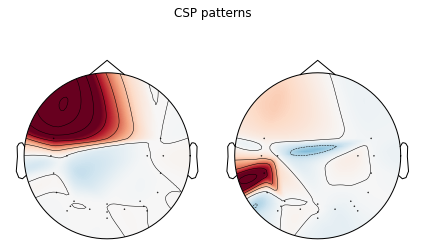

In [ ]:
from mne.decoding import CSP  # noqa
n_components = 2  # pick some components(default=4)
csp = CSP(n_components=n_components, reg='ledoit_wolf', norm_trace=False)
csp.fit_transform(X_S.get_data(), labels)
data = csp.patterns_

import matplotlib.pyplot as plt

evoked = X_S.average() # https://mne.tools/stable/auto_tutorials/evoked/10_evoked_overview.html

fig, axes = plt.subplots(1, 2)
for idx in range(2):
    mne.viz.plot_topomap(data[idx], X_S.info, axes=axes[idx], show=False)
fig.suptitle('CSP patterns')
fig.tight_layout()

In [ ]:
from sklearn.svm import SVC  # noqa
from sklearn.model_selection import ShuffleSplit  # noqa
from mne.decoding import CSP  # noqa
from sklearn.pipeline import Pipeline  # noqa
from sklearn.model_selection import cross_val_score  # noqa
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

#epochs_data = psd_all
epochs_data = X_S.get_data()

scores = []
# https://mne.tools/0.16/auto_examples/decoding/plot_decoding_csp_space.html
n_components = 4  # pick some components(default=4)
svc = SVC(C=1, kernel='linear')
csp = CSP(n_components=n_components, reg='ledoit_wolf', norm_trace=False)

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

clf = Pipeline([('CSP', csp), ('SVC', svc)])

for train_idx, test_idx in cv.split(labels):
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data[train_idx], y_train)
    X_test = csp.transform(epochs_data[test_idx])

    # fit classifier
    svc.fit(X_train, y_train)

    scores.append(svc.score(X_test, y_test))
    
# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f"%(np.mean(scores),class_balance))
# Classification accuracy: 0.208807 / Chance level: 0.750000

Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 21 dim * 2.4e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 21 dim * 2.4e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 21 dim * 2.4e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00012 (2.2e-16 eps * 21 dim * 2.5e+10  max singular v

In [ ]:
from sklearn.svm import SVC  # noqa
from sklearn.model_selection import ShuffleSplit  # noqa
from mne.decoding import CSP  # noqa
from sklearn.pipeline import Pipeline  # noqa
from sklearn.model_selection import cross_val_score  # noqa
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

#epochs_data = psd_all
#epochs_data = X_data
epochs_data = np.concatenate((X_data[:, :, 0:250], X_data[:, :, 250:500],X_data[:, :, 500:750],X_data[:, :, 750:1000]),axis = 0)
labels = np.concatenate((X_S.events[:, 2],X_S.events[:, 2],X_S.events[:, 2],X_S.events[:, 2]), axis = 0)

scores = []
# https://mne.tools/0.16/auto_examples/decoding/plot_decoding_csp_space.html
n_components = 4  # pick some components(default=4)
svc = SVC(C=1, kernel='linear')
csp = CSP(n_components=n_components, reg='ledoit_wolf', norm_trace=False)

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

clf = Pipeline([('CSP', csp), ('SVC', svc)])

for train_idx, test_idx in cv.split(labels):
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data[train_idx], y_train)
    X_test = csp.transform(epochs_data[test_idx])

    # fit classifier
    svc.fit(X_train, y_train)

    scores.append(svc.score(X_test, y_test))
    
# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f"%(np.mean(scores),class_balance))
# Classification accuracy: 0.232883 / Chance level: 0.750000

Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 21 dim * 2.3e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 21 dim * 2.4e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 21 dim * 2.3e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 21 dim * 2.4e+10  max singular v

In [ ]:
from sklearn.svm import SVC  # noqa
from sklearn.model_selection import ShuffleSplit  # noqa
from mne.decoding import CSP  # noqa
from sklearn.pipeline import Pipeline  # noqa
from sklearn.model_selection import cross_val_score  # noqa

n_components = 4  # pick some components(default=4)
svc = SVC(kernel='rbf', class_weight='balanced', C=10, gamma=1)
csp = CSP(n_components=n_components, reg='ledoit_wolf', norm_trace=False)
# Define a monte-carlo cross-validation generator (reduce variance):
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
scores = []
epochs_data = X_S.get_data()

for train_idx, test_idx in cv.split(labels):
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data[train_idx], y_train)
    X_test = csp.transform(epochs_data[test_idx])

    # fit classifier
    svc.fit(X_train, y_train)

    scores.append(svc.score(X_test, y_test))

class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f"%(np.mean(scores),class_balance))
# Classification accuracy: 0.236080 / Chance level: 0.750000

Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 21 dim * 2.4e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 21 dim * 2.4e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 21 dim * 2.4e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00012 (2.2e-16 eps * 21 dim * 2.5e+10  max singular v

In [ ]:
from sklearn.svm import SVC  # noqa
from sklearn.model_selection import ShuffleSplit  # noqa
from mne.decoding import CSP  # noqa
from sklearn.pipeline import Pipeline  # noqa
from sklearn.model_selection import cross_val_score  # noqa

n_components = 4  # pick some components(default=4)
svc = SVC(kernel='rbf', class_weight='balanced', C=10, gamma=1)
csp = CSP(n_components=n_components, reg='ledoit_wolf', norm_trace=False)
# Define a monte-carlo cross-validation generator (reduce variance):
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
scores = []
#epochs_data = psd_all
#epochs_data = X_data
epochs_data = np.concatenate((X_data[:, :, 0:250], X_data[:, :, 250:500],X_data[:, :, 500:750],X_data[:, :, 750:1000]),axis = 0)
labels = np.concatenate((X_S.events[:, 2],X_S.events[:, 2],X_S.events[:, 2],X_S.events[:, 2]), axis = 0)

for train_idx, test_idx in cv.split(labels):
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data[train_idx], y_train)
    X_test = csp.transform(epochs_data[test_idx])

    # fit classifier
    svc.fit(X_train, y_train)

    scores.append(svc.score(X_test, y_test))

class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f"%(np.mean(scores),class_balance))
# Classification accuracy: 0.257367 / Chance level: 0.750000

Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 21 dim * 2.3e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 21 dim * 2.4e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 21 dim * 2.3e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 21 dim * 2.4e+10  max singular v

In [ ]:
from sklearn.svm import SVC  # noqa
from sklearn.model_selection import ShuffleSplit  # noqa
from mne.decoding import CSP  # noqa
from sklearn.pipeline import Pipeline  # noqa
from sklearn.model_selection import cross_val_score  # noqa

n_components = 4  # pick some components(default=4)
svc = SVC(kernel='rbf', class_weight='balanced', C=10, gamma=1)
csp = CSP(n_components=n_components, reg='ledoit_wolf', norm_trace=False)
# Define a monte-carlo cross-validation generator (reduce variance):
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
scores = []
#epochs_data = psd_all
#epochs_data = X_data

[psd_all, freqs] = mne.time_frequency.psd_welch(X_S)
epochs_data = psd_all
#epochs_data = np.concatenate((X_data[:, :, 0:250], X_data[:, :, 250:500],X_data[:, :, 500:750],X_data[:, :, 750:1000]),axis = 0)
#labels = np.concatenate((X_S.events[:, 2],X_S.events[:, 2],X_S.events[:, 2],X_S.events[:, 2]), axis = 0)

for train_idx, test_idx in cv.split(labels):
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data[train_idx], y_train)
    X_test = csp.transform(epochs_data[test_idx])

    # fit classifier
    svc.fit(X_train, y_train)

    scores.append(svc.score(X_test, y_test))

class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f"%(np.mean(scores),class_balance))
# Classification accuracy: 0.262784 / Chance level: 0.750000

Effective window size : 1.000 (s)
Computing rank from data with rank=None
    Using tolerance 2.6e-11 (2.2e-16 eps * 21 dim * 5.5e+03  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-10 (2.2e-16 eps * 21 dim * 2.4e+04  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 7e-11 (2.2e-16 eps * 21 dim * 1.5e+04  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-10 (2.2e-16 eps * 

In [ ]:
from sklearn.svm import SVC  # noqa
from sklearn.model_selection import ShuffleSplit  # noqa
from mne.decoding import CSP  # noqa
from sklearn.pipeline import Pipeline  # noqa
from sklearn.model_selection import cross_val_score  # noqa

# https://mne.tools/0.16/auto_examples/decoding/plot_decoding_csp_space.html
n_components = 4  # pick some components(default=4)
svc = SVC(C=1, kernel='sigmoid')
csp = CSP(n_components=n_components, reg='ledoit_wolf', norm_trace=False)
# Define a monte-carlo cross-validation generator (reduce variance):
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
scores = []
epochs_data = X_data

for train_idx, test_idx in cv.split(labels):
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data[train_idx], y_train)
    X_test = csp.transform(epochs_data[test_idx])

    # fit classifier
    svc.fit(X_train, y_train)

    scores.append(svc.score(X_test, y_test))


# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f"%(np.mean(scores),class_balance))
# Classification accuracy: 0.243182 / Chance level: 0.750000

Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 21 dim * 2.4e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 21 dim * 2.4e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 21 dim * 2.4e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00012 (2.2e-16 eps * 21 dim * 2.5e+10  max singular v

In [ ]:
from sklearn.svm import SVC  # noqa
from sklearn.model_selection import ShuffleSplit  # noqa
from mne.decoding import CSP  # noqa
from sklearn.pipeline import Pipeline  # noqa
from sklearn.model_selection import cross_val_score  # noqa

# https://mne.tools/0.16/auto_examples/decoding/plot_decoding_csp_space.html
n_components = 4  # pick some components(default=4)
svc = SVC(C=1, kernel='sigmoid')
csp = CSP(n_components=n_components, reg='ledoit_wolf', norm_trace=False)
# Define a monte-carlo cross-validation generator (reduce variance):
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
scores = []
#epochs_data = X_data
epochs_data = np.concatenate((X_data[:, :, 0:250], X_data[:, :, 250:500],X_data[:, :, 500:750],X_data[:, :, 750:1000]),axis = 0)
labels = np.concatenate((X_S.events[:, 2],X_S.events[:, 2],X_S.events[:, 2],X_S.events[:, 2]), axis = 0)

for train_idx, test_idx in cv.split(labels):
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data[train_idx], y_train)
    X_test = csp.transform(epochs_data[test_idx])

    # fit classifier
    svc.fit(X_train, y_train)

    scores.append(svc.score(X_test, y_test))


# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f"%(np.mean(scores),class_balance))
# Classification accuracy: 0.253737 / Chance level: 0.750000

Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 21 dim * 2.3e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 21 dim * 2.4e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 21 dim * 2.3e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 21 dim * 2.4e+10  max singular v

In [ ]:
from sklearn.svm import SVC  # noqa
from sklearn.model_selection import ShuffleSplit  # noqa
from mne.decoding import CSP  # noqa
from sklearn.pipeline import Pipeline  # noqa
from sklearn.model_selection import cross_val_score  # noqa

# https://mne.tools/0.16/auto_examples/decoding/plot_decoding_csp_space.html
n_components = 4  # pick some components(default=4)
svc = SVC(C=10, kernel='poly')
csp = CSP(n_components=n_components, reg='ledoit_wolf', norm_trace=False)
# Define a monte-carlo cross-validation generator (reduce variance):
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
scores = []
epochs_data = X_data

for train_idx, test_idx in cv.split(labels):
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data[train_idx], y_train)
    X_test = csp.transform(epochs_data[test_idx])

    # fit classifier
    svc.fit(X_train, y_train)

    scores.append(svc.score(X_test, y_test))


# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f"%(np.mean(scores),class_balance))
# Classification accuracy: 0.232102 / Chance level: 0.750000

Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 21 dim * 2.4e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 21 dim * 2.4e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 21 dim * 2.4e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00012 (2.2e-16 eps * 21 dim * 2.5e+10  max singular v

In [ ]:
from sklearn.svm import SVC  # noqa
from sklearn.model_selection import ShuffleSplit  # noqa
from mne.decoding import CSP  # noqa
from sklearn.pipeline import Pipeline  # noqa
from sklearn.model_selection import cross_val_score  # noqa

# https://mne.tools/0.16/auto_examples/decoding/plot_decoding_csp_space.html
n_components = 4  # pick some components(default=4)
svc = SVC(C=10, kernel='poly')
csp = CSP(n_components=n_components, reg='ledoit_wolf', norm_trace=False)
# Define a monte-carlo cross-validation generator (reduce variance):
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
scores = []
#epochs_data = X_data
epochs_data = np.concatenate((X_data[:, :, 0:250], X_data[:, :, 250:500],X_data[:, :, 500:750],X_data[:, :, 750:1000]),axis = 0)
labels = np.concatenate((X_S.events[:, 2],X_S.events[:, 2],X_S.events[:, 2],X_S.events[:, 2]), axis = 0)

for train_idx, test_idx in cv.split(labels):
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data[train_idx], y_train)
    X_test = csp.transform(epochs_data[test_idx])

    # fit classifier
    svc.fit(X_train, y_train)

    scores.append(svc.score(X_test, y_test))


# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f"%(np.mean(scores),class_balance))
# Classification accuracy: 0.241637 / Chance level: 0.750000

Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 21 dim * 2.3e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 21 dim * 2.4e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 21 dim * 2.3e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 21 dim * 2.4e+10  max singular v

# LFCNN

### Classify Paradigm: Event = {0,1,2} -> Pron-Inner-Vis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne import io
from Data_extractions import Extract_block_data_from_subject, Extract_data_from_subject
from Data_processing import Filter_by_condition, Filter_by_class
from Utilitys import Ensure_dir, picks_from_channels

root_dir = '/content/drive/MyDrive/CPSC554X_Project/dataset'
N_S_list = [1,2,3,4,5,6,7,8]

N_B_arr=[1,2,3]
S = 0
epochs = []
data=dict()
y=dict()

# Data Parameters
datatype="EEG"
#Condition_list=["Pron","In", "Vis"]
Condition_list = ["all"]
#Classes_list=[ "up", "down", "left", "right"]
Classes_list = [ "all"]
#channels = ["CL", "CR", "OPZ", "OL", "OR"] # paradigm
channels = ["OZ", "OL", "CR", "CL", "FZ", "FR"] #class
picks = []

# Get picks for the selected channels
for i in channels:
  picks.append(picks_from_channels(i))

picks = np.concatenate(picks)
picks.tolist()

# In[]: Load Data
N_B = 1
N_S = 1

# Load a single subject to use the Epoched Object structure
X_S , Y = Extract_block_data_from_subject(root_dir,N_S,datatype,N_B=N_B)

Adquisition_eq="biosemi128"
montage = mne.channels.make_standard_montage(Adquisition_eq)
X_S.set_montage(montage)

# Get picks for the selected channels
count=1

for Classes in Classes_list: 
  for Cond in Condition_list:

    for N_S in N_S_list:

        # Load full subject's data
        X1, Y1 = Extract_data_from_subject(root_dir, N_S, datatype)

        # Filter by condition
        X_cond , Y_cond = Filter_by_condition(X1,Y1,Condition=Cond)

        # Filter by class
        X_class , Y_class = Filter_by_class(X_cond,Y_cond,Class=Classes)
        
        if count==1:  
            X_data = X_class
            Y_data = Y_class
        #    X_data = X1
        #    Y_data = Y1
            count=2
        else:
            #X_data = np.vstack((X_data,X1))
            #Y_data = np.vstack((Y_data,Y1))
            X_data = np.vstack((X_data,X_class))
            Y_data = np.vstack((Y_data,Y_class))

# Put all data
X_S._data=X_data
X_S.events=Y_data
X_S = X_S.pick_channels(picks)
X_S = X_S.crop(tmin = 0, tmax = 4)
X_data = X_S._data
labels = X_S.events[:, 2]

In [ ]:
print(labels)

[0 0 0 ... 2 2 2]


importing from tuple
input shapes: X- (4440, 25, 1025) targets- (4440, 1)
Preprocessing:
Scaling to interval 0.0 - 60.0
Splitting sets
Preprocessed: (4440, 1, 1025, 25) (4440, 3) folds: 6 x 740
Prepocessed sample shape: (1, 1025, 25)
Target shape actual/metadata:  (3,) (3,)
Saving TFRecord# 0
Setting reg for dmx, to l1
Built: dmx input: (None, 1, 1025, 25)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 1025, 32)
Setting reg for fc, to l1
Built: fc input: (None, 1, 205, 32)
Input shape: (1, 1025, 25)
y_pred: (None, 3)
Initialization complete!
Epoch 1/25
100/100 - 3s - loss: 2.6041 - cat_ACC: 0.4482 - val_loss: 2.2833 - val_cat_ACC: 0.5404 - 3s/epoch - 35ms/step
Epoch 2/25
100/100 - 3s - loss: 2.1890 - cat_ACC: 0.5766 - val_loss: 2.0677 - val_cat_ACC: 0.5684 - 3s/epoch - 26ms/step
Epoch 3/25
100/100 - 3s - loss: 1.9636 - cat_ACC: 0.6325 - val_loss: 1.9059 - val_cat_ACC: 0.5832 - 3s/epoch - 26ms/step
Epoch 4/25
100/100 - 3s - loss: 1.7870 - cat_ACC: 0.6636 - val_loss: 1.8111 -

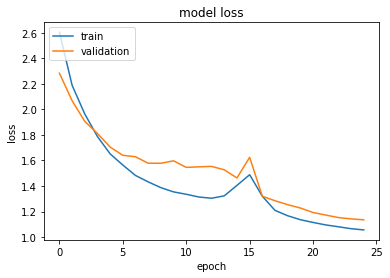

1/1 [==============================] - 0s 150ms/step - loss: 1.1427 - cat_ACC: 0.6135


In [ ]:
# https://github.com/zubara/mneflow/blob/master/examples/mneflow_example_tf2.ipynb
import numpy as np

import mne
mne.set_log_level(verbose='CRITICAL')
from mne.datasets import multimodal

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

import mneflow

#Specify import options
import_opt = dict(savepath='../tfr/',  # path where TFR files will be saved
                  out_name='mne_sample_epochs',  # name of TFRecords files
                  fs=256,
                  input_type='trials',
                  target_type='int',
                  #picks={'eeg':'grad'},
                  scale=True,  # apply baseline_scaling
                  crop_baseline=True,  # remove baseline interval after scaling
                  decimate=None,
                  scale_interval=(0, 60),  # indices in time axis corresponding to baseline interval
                  n_folds=5,  # validation set size set to 20% of all data
                  overwrite=True,
                  segment=False,
                  test_set='holdout')

X = X_S.get_data()
#X = psd_all
y = labels
meta = mneflow.produce_tfrecords((X,y),**import_opt)
dataset = mneflow.Dataset(meta, train_batch=100)

lf_params = dict(n_latent=32, #number of latent factors
                  filter_length=17, #convolutional filter length in time samples
                  nonlin = tf.nn.relu,
                  padding = 'SAME',
                  pooling = 5,#pooling factor
                  stride = 5, #stride parameter for pooling layer
                  pool_type='max',
                  model_path = import_opt['savepath'],
                  dropout = .5,
                  l1_scope = ["weights"],
                  l1=3e-3)

model = mneflow.models.LFCNN(dataset, lf_params)
model.build()

#train the model for 10 epochs
model.train(n_epochs=25, eval_step=100, early_stopping=5)
model.plot_hist()

test_loss, test_acc = model.evaluate(meta['test_paths'])
# Updating log: test loss: 1.1427 test metric: 0.6135

importing from tuple
input shapes: X- (4440, 25, 1025) targets- (4440, 1)
Preprocessing:
Scaling to interval 0.0 - 60.0
Splitting sets
Preprocessed: (4440, 1, 1025, 25) (4440, 3) folds: 6 x 740
Prepocessed sample shape: (1, 1025, 25)
Target shape actual/metadata:  (3,) (3,)
Saving TFRecord# 0
Setting reg for dmx, to l1
Built: dmx input: (None, 1, 1025, 25)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 1025, 32)
Setting reg for fc, to l1
Built: fc input: (None, 1, 205, 32)
Input shape: (1, 1025, 25)
y_pred: (None, 3)
Initialization complete!
Epoch 1/25
100/100 - 3s - loss: 2.5895 - cat_ACC: 0.4605 - val_loss: 2.3437 - val_cat_ACC: 0.5242 - 3s/epoch - 34ms/step
Epoch 2/25
100/100 - 2s - loss: 2.2027 - cat_ACC: 0.5808 - val_loss: 2.1476 - val_cat_ACC: 0.5371 - 2s/epoch - 23ms/step
Epoch 3/25
100/100 - 2s - loss: 1.9644 - cat_ACC: 0.6472 - val_loss: 1.9941 - val_cat_ACC: 0.5484 - 2s/epoch - 23ms/step
Epoch 4/25
100/100 - 2s - loss: 1.7887 - cat_ACC: 0.6750 - val_loss: 1.9198 -

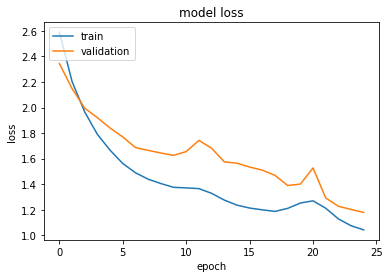

1/1 [==============================] - 0s 137ms/step - loss: 1.1598 - cat_ACC: 0.5892


In [ ]:
# https://github.com/zubara/mneflow/blob/master/examples/mneflow_example_tf2.ipynb
import numpy as np

import mne
mne.set_log_level(verbose='CRITICAL')
from mne.datasets import multimodal

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

import mneflow

#Specify import options
import_opt = dict(savepath='../tfr/',  # path where TFR files will be saved
                  out_name='mne_sample_epochs',  # name of TFRecords files
                  fs=256,
                  input_type='trials',
                  target_type='int',
                  #picks={'eeg':'grad'},
                  scale=True,  # apply baseline_scaling
                  crop_baseline=True,  # remove baseline interval after scaling
                  decimate=None,
                  scale_interval=(0, 60),  # indices in time axis corresponding to baseline interval
                  n_folds=5,  # validation set size set to 20% of all data
                  overwrite=True,
                  segment=False,
                  test_set='holdout')

#X = X_S.get_data()
#X = psd_all
X = np.concatenate((X_data[:, :, 0:250], X_data[:, :, 250:500],X_data[:, :, 500:750],X_data[:, :, 750:1000]),axis = 0)
labels = np.concatenate((X_S.events[:, 2],X_S.events[:, 2],X_S.events[:, 2],X_S.events[:, 2]), axis = 0)
y = labels
meta = mneflow.produce_tfrecords((X,y),**import_opt)
dataset = mneflow.Dataset(meta, train_batch=100)

lf_params = dict(n_latent=32, #number of latent factors
                  filter_length=17, #convolutional filter length in time samples
                  nonlin = tf.nn.relu,
                  padding = 'SAME',
                  pooling = 5,#pooling factor
                  stride = 5, #stride parameter for pooling layer
                  pool_type='max',
                  model_path = import_opt['savepath'],
                  dropout = .5,
                  l1_scope = ["weights"],
                  l1=3e-3)

model = mneflow.models.LFCNN(dataset, lf_params)
model.build()

#train the model for 10 epochs
model.train(n_epochs=25, eval_step=100, early_stopping=5)
model.plot_hist()

test_loss, test_acc = model.evaluate(meta['test_paths'])

### Classify Word: Event = {31,32,33,34} -> Up-Down-Right-Left

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne import io
from Data_extractions import Extract_block_data_from_subject, Extract_data_from_subject
from Data_processing import Filter_by_condition, Filter_by_class
from Utilitys import Ensure_dir, picks_from_channels

root_dir = '/content/drive/MyDrive/CPSC554X_Project/dataset'
N_S_list = [1,2,3,4,5,6,7,8]
N_B_arr=[1,2,3]
S = 0
epochs = []
data=dict()
y=dict()

# Data Parameters
datatype="EEG"
#Condition_list=["Pron","In", "Vis"]
Condition_list = ["Inner"]
#Classes_list=[ "up", "down", "left", "right"]
Classes_list = [ "all"]
channels = ["CL", "CR", "OPZ", "OL", "OR"] # paradigm
#channels = ["OZ", "OL", "CR", "CL", "FZ", "FR"] #class
picks = []

# Get picks for the selected channels
for i in channels:
  picks.append(picks_from_channels(i))

picks = np.concatenate(picks)
picks.tolist()

# In[]: Load Data
N_B = 1
N_S = 1

# Load a single subject to use the Epoched Object structure
X_S , Y = Extract_block_data_from_subject(root_dir,N_S,datatype,N_B=N_B)

Adquisition_eq="biosemi128"
montage = mne.channels.make_standard_montage(Adquisition_eq)
X_S.set_montage(montage)

# Get picks for the selected channels
count=1

for Classes in Classes_list: 
  for Cond in Condition_list:

    for N_S in N_S_list:

        # Load full subject's data
        X1, Y1 = Extract_data_from_subject(root_dir, N_S, datatype)

        # Filter by condition
        X_cond , Y_cond = Filter_by_condition(X1,Y1,Condition=Cond)
        Y_cond[:,1] = Y_cond[:,1] + 31
        Y_cond[:, [1, 2]] = Y_cond[:, [2, 1]]
        
        # Filter by class
        X_class , Y_class = Filter_by_class(X_cond,Y_cond,Class=Classes)
        
        if count==1:  
            X_data = X_class
            Y_data = Y_class
        #    X_data = X1
        #    Y_data = Y1
            count=2
        else:
            #X_data = np.vstack((X_data,X1))
            #Y_data = np.vstack((Y_data,Y1))
            X_data = np.vstack((X_data,X_class))
            Y_data = np.vstack((Y_data,Y_class))

# Put all data
X_S._data=X_data
X_S.events=Y_data
X_S = X_S.pick_channels(picks)
X_S = X_S.crop(tmin = 0, tmax = 4)
X_data = X_S._data
labels = X_S.events[:, 2]

importing from tuple
input shapes: X- (1756, 21, 1025) targets- (1756, 1)
Preprocessing:
Scaling to interval 0.0 - 60.0
Splitting sets
Preprocessed: (1756, 1, 1025, 21) (1756, 4) folds: 6 x 292
Prepocessed sample shape: (1, 1025, 21)
Target shape actual/metadata:  (4,) (4,)
Saving TFRecord# 0
Setting reg for dmx, to l1
Built: dmx input: (None, 1, 1025, 21)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 1025, 32)
Setting reg for fc, to l1
Built: fc input: (None, 1, 205, 32)
Input shape: (1, 1025, 21)
y_pred: (None, 4)
Initialization complete!
Epoch 1/25
100/100 - 3s - loss: 3.0708 - cat_ACC: 0.3321 - val_loss: 2.9256 - val_cat_ACC: 0.2815 - 3s/epoch - 30ms/step
Epoch 2/25
100/100 - 2s - loss: 2.5580 - cat_ACC: 0.4952 - val_loss: 2.6986 - val_cat_ACC: 0.2479 - 2s/epoch - 21ms/step
Epoch 3/25
100/100 - 2s - loss: 2.1972 - cat_ACC: 0.6095 - val_loss: 2.5616 - val_cat_ACC: 0.2689 - 2s/epoch - 21ms/step
Epoch 4/25
100/100 - 2s - loss: 1.9455 - cat_ACC: 0.6797 - val_loss: 2.5385 -

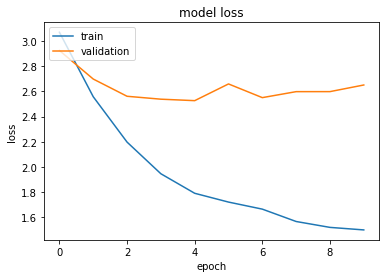

1/1 [==============================] - 0s 76ms/step - loss: 2.4804 - cat_ACC: 0.2877


In [ ]:
# https://github.com/zubara/mneflow/blob/master/examples/mneflow_example_tf2.ipynb
import numpy as np

import mne
mne.set_log_level(verbose='CRITICAL')
from mne.datasets import multimodal

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

import mneflow

#Specify import options
import_opt = dict(savepath='../tfr/',  # path where TFR files will be saved
                  out_name='mne_sample_epochs',  # name of TFRecords files
                  fs=256,
                  input_type='trials',
                  target_type='int',
                  #picks={'eeg':'grad'},
                  scale=True,  # apply baseline_scaling
                  crop_baseline=True,  # remove baseline interval after scaling
                  decimate=None,
                  scale_interval=(0, 60),  # indices in time axis corresponding to baseline interval
                  n_folds=5,  # validation set size set to 20% of all data
                  overwrite=True,
                  segment=False,
                  test_set='holdout')

X = X_S.get_data()
#X = psd_all
y = labels
meta = mneflow.produce_tfrecords((X,y),**import_opt)
dataset = mneflow.Dataset(meta, train_batch=100)

lf_params = dict(n_latent=32, #number of latent factors
                  filter_length=17, #convolutional filter length in time samples
                  nonlin = tf.nn.relu,
                  padding = 'SAME',
                  pooling = 5,#pooling factor
                  stride = 5, #stride parameter for pooling layer
                  pool_type='max',
                  model_path = import_opt['savepath'],
                  dropout = .5,
                  l1_scope = ["weights"],
                  l1=3e-3)

model = mneflow.models.LFCNN(dataset, lf_params)
model.build()

#train the model for 10 epochs
model.train(n_epochs=25, eval_step=100, early_stopping=5)
model.plot_hist()

test_loss, test_acc = model.evaluate(meta['test_paths'])
# test loss: 2.4804 test metric: 0.2877

importing from tuple
input shapes: X- (7024, 21, 250) targets- (7024, 1)
Preprocessing:
Scaling to interval 0.0 - 60.0
Splitting sets
Preprocessed: (7024, 1, 250, 21) (7024, 4) folds: 6 x 1170
Prepocessed sample shape: (1, 250, 21)
Target shape actual/metadata:  (4,) (4,)
Saving TFRecord# 0
Setting reg for dmx, to l1
Built: dmx input: (None, 1, 250, 21)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 250, 32)
Setting reg for fc, to l1
Built: fc input: (None, 1, 50, 32)
Input shape: (1, 250, 21)
y_pred: (None, 4)
Initialization complete!
Epoch 1/25
100/100 - 2s - loss: 2.6743 - cat_ACC: 0.2493 - val_loss: 2.4969 - val_cat_ACC: 0.2500 - 2s/epoch - 25ms/step
Epoch 2/25
100/100 - 1s - loss: 2.4634 - cat_ACC: 0.2575 - val_loss: 2.3670 - val_cat_ACC: 0.2510 - 1s/epoch - 13ms/step
Epoch 3/25
100/100 - 1s - loss: 2.3167 - cat_ACC: 0.2700 - val_loss: 2.2476 - val_cat_ACC: 0.2460 - 1s/epoch - 13ms/step
Epoch 4/25
100/100 - 1s - loss: 2.1852 - cat_ACC: 0.2859 - val_loss: 2.1382 - val_c

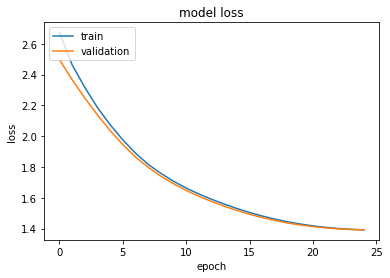

1/1 [==============================] - 0s 92ms/step - loss: 1.3911 - cat_ACC: 0.2530


In [ ]:
# https://github.com/zubara/mneflow/blob/master/examples/mneflow_example_tf2.ipynb
import numpy as np

import mne
mne.set_log_level(verbose='CRITICAL')
from mne.datasets import multimodal

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

import mneflow

#Specify import options
import_opt = dict(savepath='../tfr/',  # path where TFR files will be saved
                  out_name='mne_sample_epochs',  # name of TFRecords files
                  fs=256,
                  input_type='trials',
                  target_type='int',
                  #picks={'eeg':'grad'},
                  scale=True,  # apply baseline_scaling
                  crop_baseline=True,  # remove baseline interval after scaling
                  decimate=None,
                  scale_interval=(0, 60),  # indices in time axis corresponding to baseline interval
                  n_folds=5,  # validation set size set to 20% of all data
                  overwrite=True,
                  segment=False,
                  test_set='holdout')

#X = X_S.get_data()
#X = psd_all
X = np.concatenate((X_data[:, :, 0:250], X_data[:, :, 250:500],X_data[:, :, 500:750],X_data[:, :, 750:1000]),axis = 0)
labels = np.concatenate((X_S.events[:, 2],X_S.events[:, 2],X_S.events[:, 2],X_S.events[:, 2]), axis = 0)
y = labels
meta = mneflow.produce_tfrecords((X,y),**import_opt)
dataset = mneflow.Dataset(meta, train_batch=100)

lf_params = dict(n_latent=32, #number of latent factors
                  filter_length=17, #convolutional filter length in time samples
                  nonlin = tf.nn.relu,
                  padding = 'SAME',
                  pooling = 5,#pooling factor
                  stride = 5, #stride parameter for pooling layer
                  pool_type='max',
                  model_path = import_opt['savepath'],
                  dropout = .5,
                  l1_scope = ["weights"],
                  l1=3e-3)

model = mneflow.models.LFCNN(dataset, lf_params)
model.build()

#train the model for 10 epochs
model.train(n_epochs=25, eval_step=100, early_stopping=5)
model.plot_hist()

test_loss, test_acc = model.evaluate(meta['test_paths'])
# test loss: 1.3911 test metric: 0.2530

# KNN with Riemannian

### Classify Paradigm: Event = {0,1,2} -> Pron-Inner-Vis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne import io
from Data_extractions import Extract_block_data_from_subject, Extract_data_from_subject
from Data_processing import Filter_by_condition, Filter_by_class
from Utilitys import Ensure_dir, picks_from_channels

root_dir = '/content/drive/MyDrive/CPSC554X_Project/dataset'
N_S_list = [1,2,3,4,5,6,7,8]

N_B_arr=[1,2,3]
S = 0
epochs = []
data=dict()
y=dict()

# Data Parameters
datatype="EEG"
#Condition_list=["Pron","In", "Vis"]
Condition_list = ["all"]
#Classes_list=[ "up", "down", "left", "right"]
Classes_list = [ "all"]
#channels = ["CL", "CR", "OPZ", "OL", "OR"] # paradigm
channels = ["OZ", "OL", "CR", "CL", "FZ", "FR"] #class
picks = []

# Get picks for the selected channels
for i in channels:
  picks.append(picks_from_channels(i))

picks = np.concatenate(picks)
picks.tolist()

# In[]: Load Data
N_B = 1
N_S = 1

# Load a single subject to use the Epoched Object structure
X_S , Y = Extract_block_data_from_subject(root_dir,N_S,datatype,N_B=N_B)

Adquisition_eq="biosemi128"
montage = mne.channels.make_standard_montage(Adquisition_eq)
X_S.set_montage(montage)

# Get picks for the selected channels
count=1

for Classes in Classes_list: 
  for Cond in Condition_list:

    for N_S in N_S_list:

        # Load full subject's data
        X1, Y1 = Extract_data_from_subject(root_dir, N_S, datatype)

        # Filter by condition
        X_cond , Y_cond = Filter_by_condition(X1,Y1,Condition=Cond)

        # Filter by class
        X_class , Y_class = Filter_by_class(X_cond,Y_cond,Class=Classes)
        
        if count==1:  
            X_data = X_class
            Y_data = Y_class
        #    X_data = X1
        #    Y_data = Y1
            count=2
        else:
            #X_data = np.vstack((X_data,X1))
            #Y_data = np.vstack((Y_data,Y1))
            X_data = np.vstack((X_data,X_class))
            Y_data = np.vstack((Y_data,Y_class))

# Put all data
X_S._data=X_data
X_S.events=Y_data
X_S = X_S.pick_channels(picks)
X_S = X_S.crop(tmin = 0, tmax = 4)
X_data = X_S._data
labels = X_S.events[:, 2]

In [ ]:
import pyriemann
from sklearn.model_selection import cross_val_score

from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
from pyriemann.estimation import XdawnCovariances
from pyriemann.classification import MDM
from pyriemann.classification import KNearestNeighbor
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.preprocessing import FunctionTransformer

n_components = 'cov'  # pick some components

# Define a monte-carlo cross-validation generator (reduce variance):
cv = KFold(n_splits=10, shuffle=True, random_state=42)
#cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
pr = np.zeros(len(labels))
epochs_data = X_S._data


print("Multiclass classification with Covariance + KNN")
# Perform a simple covariance matrix estimation for each given trial.

clf = make_pipeline(Covariances(n_components),KNearestNeighbor())
#print(Covariances(n_components))
#knn = KNearestNeighbor()
for train_idx, test_idx in cv.split(epochs_data):
    y_train, y_test = labels[train_idx], labels[test_idx]
    clf.fit(epochs_data[train_idx], y_train)
    #print(epochs_data[train_idx].shape)
    #print(epochs_data[train_idx].shape)
    #print(pr[test_idx].shape)
    print('1')
    pr[test_idx] = clf.predict(epochs_data[test_idx])

print(classification_report(labels, pr))

Multiclass classification with Covariance + KNN
1
1
1
1
1
1
1
1
1
1
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       888
           1       0.89      0.83      0.86      1756
           2       0.84      0.91      0.88      1796

    accuracy                           0.89      4440
   macro avg       0.90      0.89      0.90      4440
weighted avg       0.89      0.89      0.89      4440



In [ ]:
import pyriemann
from sklearn.model_selection import cross_val_score

from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
from pyriemann.estimation import XdawnCovariances
from pyriemann.classification import MDM
from pyriemann.classification import KNearestNeighbor
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)



n_components = 'cov'  # pick some components

# Define a monte-carlo cross-validation generator (reduce variance):
cv = KFold(n_splits=10, shuffle=True, random_state=42)
#[psd_all, freqs] = mne.time_frequency.psd_welch(X_S)
#epochs_data = psd_all
#epochs_data = X_data
epochs_data = np.concatenate((X_data[:, :, 0:250], X_data[:, :, 250:500],X_data[:, :, 500:750],X_data[:, :, 750:1000]),axis = 0)
labels = np.concatenate((X_S.events[:, 2],X_S.events[:, 2],X_S.events[:, 2],X_S.events[:, 2]), axis = 0)
pr = np.zeros(len(labels))
print("Multiclass classification with Covariance + KNN")
# Perform a simple covariance matrix estimation for each given trial.

clf = make_pipeline(Covariances(), KNearestNeighbor())
#clf = KNearestNeighbor()

for train_idx, test_idx in cv.split(epochs_data):
    y_train, y_test = labels[train_idx], labels[test_idx]
    print("1")
    clf.fit(epochs_data[train_idx], y_train)
    pr[test_idx] = clf.predict(epochs_data[test_idx])

print(classification_report(labels, pr))

Multiclass classification with Covariance + KNN
1
1
1
1
1
1
1
1
1
1
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      3552
           1       0.74      0.72      0.73      7024
           2       0.73      0.79      0.76      7184

    accuracy                           0.77     17760
   macro avg       0.80      0.77      0.79     17760
weighted avg       0.77      0.77      0.77     17760



### Classify Word: Event = {31,32,33,34} -> Up-Down-Right-Left

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne import io
from Data_extractions import Extract_block_data_from_subject, Extract_data_from_subject
from Data_processing import Filter_by_condition, Filter_by_class
from Utilitys import Ensure_dir, picks_from_channels

root_dir = '/content/drive/MyDrive/CPSC554X_Project/dataset'
N_S_list = [1,2,3,4,5,6,7,8]
N_B_arr=[1,2,3]
S = 0
epochs = []
data=dict()
y=dict()

# Data Parameters
datatype="EEG"
#Condition_list=["Pron","In", "Vis"]
Condition_list = ["Inner"]
#Classes_list=[ "up", "down", "left", "right"]
Classes_list = [ "all"]
channels = ["CL", "CR", "OPZ", "OL", "OR"] # paradigm
#channels = ["OZ", "OL", "CR", "CL", "FZ", "FR"] #class
picks = []

# Get picks for the selected channels
for i in channels:
  picks.append(picks_from_channels(i))

picks = np.concatenate(picks)
picks.tolist()

# In[]: Load Data
N_B = 1
N_S = 1

# Load a single subject to use the Epoched Object structure
X_S , Y = Extract_block_data_from_subject(root_dir,N_S,datatype,N_B=N_B)

Adquisition_eq="biosemi128"
montage = mne.channels.make_standard_montage(Adquisition_eq)
X_S.set_montage(montage)

# Get picks for the selected channels
count=1

for Classes in Classes_list: 
  for Cond in Condition_list:

    for N_S in N_S_list:

        # Load full subject's data
        X1, Y1 = Extract_data_from_subject(root_dir, N_S, datatype)

        # Filter by condition
        X_cond , Y_cond = Filter_by_condition(X1,Y1,Condition=Cond)
        Y_cond[:,1] = Y_cond[:,1] + 31
        Y_cond[:, [1, 2]] = Y_cond[:, [2, 1]]
        
        # Filter by class
        X_class , Y_class = Filter_by_class(X_cond,Y_cond,Class=Classes)
        
        if count==1:  
            X_data = X_class
            Y_data = Y_class
        #    X_data = X1
        #    Y_data = Y1
            count=2
        else:
            #X_data = np.vstack((X_data,X1))
            #Y_data = np.vstack((Y_data,Y1))
            X_data = np.vstack((X_data,X_class))
            Y_data = np.vstack((Y_data,Y_class))

# Put all data
X_S._data=X_data
X_S.events=Y_data
X_S = X_S.pick_channels(picks)
X_S = X_S.crop(tmin = 0, tmax = 4)
X_data = X_S._data
labels = X_S.events[:, 2]

In [ ]:
import pyriemann
from sklearn.model_selection import cross_val_score

from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
from pyriemann.estimation import XdawnCovariances
from pyriemann.classification import MDM
from pyriemann.classification import KNearestNeighbor
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)



n_components = 'cov'  # pick some components

# Define a monte-carlo cross-validation generator (reduce variance):
cv = KFold(n_splits=10, shuffle=True, random_state=42)
#[psd_all, freqs] = mne.time_frequency.psd_welch(X_S)
#epochs_data = psd_all
epochs_data = X_data

pr = np.zeros(len(labels))
print("Multiclass classification with Covariance + KNN")
# Perform a simple covariance matrix estimation for each given trial.

clf = make_pipeline(Covariances(), KNearestNeighbor())
#clf = KNearestNeighbor()

for train_idx, test_idx in cv.split(epochs_data):
    y_train, y_test = labels[train_idx], labels[test_idx]
    print("1")
    clf.fit(epochs_data[train_idx], y_train)
    pr[test_idx] = clf.predict(epochs_data[test_idx])

print(classification_report(labels, pr))

Multiclass classification with Covariance + KNN
1
1
1
1
1
1
1
1
1
1
              precision    recall  f1-score   support

           0       0.25      0.35      0.29       439
           1       0.19      0.18      0.19       439
           2       0.23      0.22      0.22       439
           3       0.25      0.17      0.20       439

    accuracy                           0.23      1756
   macro avg       0.23      0.23      0.23      1756
weighted avg       0.23      0.23      0.23      1756



In [ ]:
import pyriemann
from sklearn.model_selection import cross_val_score

from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
from pyriemann.estimation import XdawnCovariances
from pyriemann.classification import MDM
from pyriemann.classification import KNearestNeighbor
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)



n_components = 'cov'  # pick some components

# Define a monte-carlo cross-validation generator (reduce variance):
cv = KFold(n_splits=10, shuffle=True, random_state=42)
#[psd_all, freqs] = mne.time_frequency.psd_welch(X_S)
#epochs_data = psd_all
#epochs_data = X_data
epochs_data = np.concatenate((X_data[:, :, 0:250], X_data[:, :, 250:500],X_data[:, :, 500:750],X_data[:, :, 750:1000]),axis = 0)
labels = np.concatenate((X_S.events[:, 2],X_S.events[:, 2],X_S.events[:, 2],X_S.events[:, 2]), axis = 0)
pr = np.zeros(len(labels))
print("Multiclass classification with Covariance + KNN")
# Perform a simple covariance matrix estimation for each given trial.

clf = make_pipeline(Covariances(), KNearestNeighbor())
#clf = KNearestNeighbor()

for train_idx, test_idx in cv.split(epochs_data):
    y_train, y_test = labels[train_idx], labels[test_idx]
    print("1")
    clf.fit(epochs_data[train_idx], y_train)
    pr[test_idx] = clf.predict(epochs_data[test_idx])

print(classification_report(labels, pr))

Multiclass classification with Covariance + KNN
1
1
1
1
1
1
1
1
1
1
              precision    recall  f1-score   support

           0       0.28      0.42      0.34      1756
           1       0.29      0.30      0.29      1756
           2       0.30      0.26      0.27      1756
           3       0.32      0.20      0.24      1756

    accuracy                           0.29      7024
   macro avg       0.30      0.29      0.29      7024
weighted avg       0.30      0.29      0.29      7024



In [ ]:
import pyriemann
from sklearn.model_selection import cross_val_score

from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
from pyriemann.estimation import XdawnCovariances
from pyriemann.classification import MDM
from pyriemann.classification import KNearestNeighbor
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

n_components = 'cov'  # pick some components

# Define a monte-carlo cross-validation generator (reduce variance):
cv = KFold(n_splits=10, shuffle=True, random_state=42)
[psd_all, freqs] = mne.time_frequency.psd_welch(X_S)
epochs_data = psd_all
#epochs_data = X_data

pr = np.zeros(len(labels))
print("Multiclass classification with Covariance + KNN")
# Perform a simple covariance matrix estimation for each given trial.

clf = make_pipeline(Covariances(), KNearestNeighbor())
#clf = KNearestNeighbor()

for train_idx, test_idx in cv.split(epochs_data):
    y_train, y_test = labels[train_idx], labels[test_idx]
    print("1")
    clf.fit(epochs_data[train_idx], y_train)
    pr[test_idx] = clf.predict(epochs_data[test_idx])

print(classification_report(labels, pr))

Multiclass classification with Covariance + KNN
1
1
1
1
1
1
1
1
1
1
              precision    recall  f1-score   support

          31       0.25      0.36      0.29       439
          32       0.28      0.32      0.30       439
          33       0.23      0.21      0.22       439
          34       0.25      0.13      0.17       439

    accuracy                           0.25      1756
   macro avg       0.25      0.25      0.24      1756
weighted avg       0.25      0.25      0.24      1756

